In [ ]:
import os
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass
from enum import Enum
import math
from typing import Any, Callable, Dict, List, Optional, Tuple
from tqdm import tqdm

try:
    from dash import Dash, dash_table, html
except ModuleNotFoundError:
    !pip install dash
    from dash import Dash, dash_table, html
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
try:
    from memory_profiler import memory_usage
except ModuleNotFoundError:
    !pip install memory-profiler
    from memory_profiler import memory_usage
from plotly.colors import qualitative
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples,
    silhouette_score,
)
from sklearn.neighbors import LocalOutlierFactor,NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.5 MB/s eta 0:00:00


# Data Processing

In [ ]:
@dataclass
class DatasetInfo:
    name: str
    drive_id: str
    label_column: Optional[str] = None
    fill_strategy: str = 'drop'
    categorical_columns: Optional[List[str]] = None
    date_columns: Optional[List[str]] = None
    normalize_columns: Optional[List[str]] = None
    keep_columns: Optional[List[str]] = None

DATASET_INFO: List[DatasetInfo] = [
    DatasetInfo(
        name='weather',
        drive_id='1lwUd4y7DAAdQ5eXdg9Cb2vSeeGDTvxmI',
        label_column='Daily_Rainfall_Total',
        fill_strategy='fill_mean',
        categorical_columns=['Region', 'Station'],
        date_columns=['Date'],
        normalize_columns=[
            'Daily_Rainfall_Total',
            'Rainfall_30min',
            'Rainfall_60min',
            'Rainfall_120min',
            'Temp_Mean',
            'Temp_Max',
            'Temp_Min',
            'Wind_Mean',
            'Wind_Max'
        ],
        keep_columns=None
    ),
    DatasetInfo(
        name='student',
        drive_id='1RDqHPIh3hl0hGKdXmKSMnDgnBd06FZSN',
        label_column='exam_score',
        fill_strategy='fill_mean',
        categorical_columns=[
            'gender',
            'part_time_job',
            'diet_quality',
            'parental_education_level',
            'internet_quality',
            'extracurricular_participation'
        ],
        date_columns=[],
        normalize_columns=[
            'age', 'study_hours_per_day', 'social_media_hours',
            'netflix_hours', 'attendance_percentage', 'sleep_hours',
            'exercise_frequency', 'mental_health_rating'
        ],
        keep_columns=None
    ),
    DatasetInfo(
        name='cars',
        drive_id='158Ch2uQKgszmGBv-5C3gZIYIiVctgY6_',
        label_column='price',
        fill_strategy='fill_mean',
        categorical_columns=[
            'brand', 'model', 'fuel_type', 'engine',
            'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'
        ],
        date_columns=[],
        normalize_columns=['model_year', 'milage'],
        keep_columns=None
    ),
    DatasetInfo(
        name='covid',
        drive_id='1tG_mw-ZiSN99JfOLDDcVn66nuCHnkpt9',
        label_column=None,
        fill_strategy='fill_mean',
        categorical_columns=['case_id'],
        date_columns=['date_reported'],
        normalize_columns=None,
        keep_columns=None
    )
]

In [ ]:
class Data:
    RAW_DATA_FOLDER_PATH = 'data/raw'

    def __init__(self, dataset_name: str):
        self.dataset_name: str = dataset_name
        self.data: Optional[pd.DataFrame] = None
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None

    # ------------------ Step 0: Load Data ------------------
    def read_raw_data(self, drive_id: str) -> 'Data':
        os.makedirs(self.RAW_DATA_FOLDER_PATH, exist_ok=True)
        url = f"https://drive.google.com/uc?id={drive_id}"
        output = os.path.join(self.RAW_DATA_FOLDER_PATH, f"{self.dataset_name}.csv")
        gdown.download(url, output, quiet=False)

        try:
            self.data = pd.read_csv(output)
        except Exception as e:
            print(f"Error reading '{output}': {e}")
            self.data = None
        return self

    # ------------------ Step 1: Clean Missing Values ------------------
    def clean_missing_values(self, strategy: str = 'drop') -> 'Data':
        if self.data is None:
            return self

        if strategy == 'drop':
            self.data.dropna(inplace=True)
        elif strategy == 'fill_zero':
            self.data.fillna(0, inplace=True)
        elif strategy == 'fill_mean':
            numeric_cols = self.data.select_dtypes(include=['number']).columns
            self.data[numeric_cols] = self.data[numeric_cols].fillna(self.data[numeric_cols].mean())
        else:
            print(f"Unknown strategy '{strategy}'")
        return self

    # ------------------ Step 2: Encode Categorical ------------------
    def encode_categorical(
        self,
        categorical_columns: Optional[List[str]] = None,
        date_columns: Optional[List[str]] = None
    ) -> 'Data':
        if self.data is None:
            return self

        # Encode object/string columns
        if categorical_columns:
          self.data[categorical_columns] = self.data[categorical_columns].apply(lambda x: pd.factorize(x)[0])

        # Encode date columns as day-of-year
        if date_columns:
            for col in date_columns:
                if col in self.data.columns:
                    self.data[col] = pd.to_datetime(self.data[col], errors='coerce').dt.dayofyear
        return self

    # ------------------ Step 3: Clean Numeric Columns ------------------
    def clean_numeric_columns(self, columns: Optional[List[str]] = None) -> 'Data':
        if self.data is None:
            return self

        if columns is None:
            # Automatically select numeric-looking columns (even if stored as object)
            columns = self.data.select_dtypes(include=['object']).columns.tolist()

        # Convert to numeric, non-numeric entries become NaN
        for col in columns:
            if col in self.data.columns:
                self.data[col] = pd.to_numeric(
                    self.data[col].astype(str).str.replace(r'[^\d\.-]', '', regex=True),
                    errors='coerce'
                )
        return self

    # ------------------ Step 4: Normalize Features ------------------
    def normalize_features(self, columns: Optional[List[str]] = None) -> 'Data':
        if self.data is None:
            return self

        if columns is None:
            columns = self.data.select_dtypes(include=['int64', 'float64']).columns.tolist()

        scaler = StandardScaler()
        self.data[columns] = scaler.fit_transform(self.data[columns])
        return self

    # ------------------ Step 5: Feature Selection ------------------
    def feature_selection(self, keep_columns: Optional[List[str]] = None) -> 'Data':
        if self.data is None or not keep_columns:
            return self

        self.data = self.data[keep_columns]
        return self

    # ------------------ Step 6: Split Features and Labels ------------------
    def split_features_labels(self, label_column: str) -> 'Data':
        if self.data is None or label_column not in self.data.columns:
            print(f"Label column '{label_column}' not found.")
            self.X = None
            self.y = None
            return self

        self.X = self.data.drop(columns=[label_column])
        self.y = self.data[label_column]
        return self

    # ------------------ Step 7: Convert to NumPy ------------------
    def get_numpy(self) -> Optional[tuple]:
        if self.X is None or self.y is None:
            print("Features or labels not defined. Run split_features_labels() first.")
            return None
        return self.X.to_numpy(), self.y.to_numpy()

    # ------------------ Inspection Methods ------------------
    def preview_dataframe(self, rows: int = 5) -> 'Data':
        if self.data is not None:
            display(self.data.head(rows))
        return self

    def get_dataframe_information(self) -> 'Data':
        if self.data is not None:
            self.data.info()
        return self

In [ ]:
processed_data: Dict[str, Data] = {}

for dataset_info in DATASET_INFO:
    processed_data[dataset_info.name] = (
        Data(dataset_info.name)
        .read_raw_data(dataset_info.drive_id)
        .clean_missing_values(strategy=dataset_info.fill_strategy)
        .encode_categorical(
            categorical_columns=dataset_info.categorical_columns,
            date_columns=dataset_info.date_columns
        )
        .clean_numeric_columns(columns=dataset_info.normalize_columns)
        .normalize_features(columns=dataset_info.normalize_columns)
        .feature_selection(keep_columns=dataset_info.keep_columns)
        .split_features_labels(label_column=dataset_info.label_column)

        # Print
        .get_dataframe_information()
        .preview_dataframe()
    )

Downloading...
From: https://drive.google.com/uc?id=1lwUd4y7DAAdQ5eXdg9Cb2vSeeGDTvxmI
To: /content/data/raw/weather.csv
100%|██████████| 4.06M/4.06M [00:00<00:00, 22.3MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68640 entries, 0 to 68639
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Region                68640 non-null  int64  
 1   Station               68640 non-null  int64  
 2   Date                  27019 non-null  float64
 3   Daily_Rainfall_Total  65076 non-null  float64
 4   Rainfall_30min        68640 non-null  float64
 5   Rainfall_60min        68640 non-null  float64
 6   Rainfall_120min       68640 non-null  float64
 7   Temp_Mean             68640 non-null  float64
 8   Temp_Max              68640 non-null  float64
 9   Temp_Min              68640 non-null  float64
 10  Wind_Mean             68640 non-null  float64
 11  Wind_Max              68640 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 6.3 MB


Region  Station   Date  Daily_Rainfall_Total  Rainfall_30min  \
0       0        0    1.0             -0.481026       -0.556252   
1       0        0   32.0             -0.481026       -0.556252   
2       0        0   61.0             -0.468318       -0.530756   
3       0        0   92.0             -0.036232        0.234116   
4       0        0  122.0             -0.481026       -0.556252   

   Rainfall_60min  Rainfall_120min  Temp_Mean  Temp_Max  Temp_Min  Wind_Mean  \
0       -0.534344        -0.525984  -0.567397 -0.601371  0.206755   5.817101   
1       -0.534344        -0.525984  -0.703217 -1.336710 -0.250259   5.045104   
2       -0.514843        -0.509353  -0.567397 -1.244793  0.549516   6.117322   
3        0.128690         0.056088  -1.653957 -1.336710 -0.021752   5.345325   
4       -0.534344        -0.525984  -0.431577 -0.141785 -0.136006   5.945767   

   Wind_Max  
0  4.146446  
1  4.339906  
2  3.390194  
3  4.533366  
4  2.194261

Downloading...
From: https://drive.google.com/uc?id=1RDqHPIh3hl0hGKdXmKSMnDgnBd06FZSN
To: /content/data/raw/student.csv
100%|██████████| 73.7k/73.7k [00:00<00:00, 66.4MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   float64
 2   gender                         1000 non-null   int64  
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   int64  
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   int64  
 10  exercise_frequency             1000 non-null   float64
 11  parental_education_level       1000 non-null   int64  
 12  internet_quality               1000 non-null   in

student_id       age  gender  study_hours_per_day  social_media_hours  \
0      S1000  1.084551       0            -2.418068           -1.114064   
1      S1001 -0.215870       0             2.281707            0.251315   
2      S1002  0.217604       1            -1.464491            0.507324   
3      S1003  1.084551       0            -1.736942            1.190013   
4      S1004 -0.649344       0             0.987566            1.616694   

   netflix_hours  part_time_job  attendance_percentage  sleep_hours  \
0      -0.669750              0               0.092426     1.248120   
1       0.446965              0               1.401696    -1.525661   
2      -0.483631              0               1.135584     1.248120   
3      -0.762810              0              -1.397800     2.227102   
4      -1.228108              0               0.720450    -1.280916   

   diet_quality  exercise_frequency  parental_education_level  \
0             0            1.461166                         0   
1             1            1.461166                         1   
2             2           -1.008689                         1   
3             2            0.473224                         0   
4             0           -0.020747                         0   

   internet_quality  mental_health_rating  extracurricular_participation  \
0                 0              0.900186                              0   
1                 0              0.900186                              1   
2                 1             -1.559339                              1   
3                 2             -1.559339                              0   
4                 2             -1.559339                              1   

   exam_score  
0        56.2  
1       100.0  
2        34.3  
3        26.8  
4        66.4

Downloading...
From: https://drive.google.com/uc?id=158Ch2uQKgszmGBv-5C3gZIYIiVctgY6_
To: /content/data/raw/cars.csv
100%|██████████| 608k/608k [00:00<00:00, 44.2MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   int64  
 1   model         4009 non-null   int64  
 2   model_year    4009 non-null   float64
 3   milage        4009 non-null   float64
 4   fuel_type     4009 non-null   int64  
 5   engine        4009 non-null   int64  
 6   transmission  4009 non-null   int64  
 7   ext_col       4009 non-null   int64  
 8   int_col       4009 non-null   int64  
 9   accident      4009 non-null   int64  
 10  clean_title   4009 non-null   int64  
 11  price         4009 non-null   object 
dtypes: float64(2), int64(9), object(1)
memory usage: 376.0+ KB


brand  model  model_year    milage  fuel_type  engine  transmission  \
0      0      0   -0.412118 -0.262336          0       0             0   
1      1      1    0.898486 -0.573255          1       1             1   
2      2      2    1.062312 -0.809820          1       2             2   
3      3      3   -0.084467  0.462467          2       3             3   
4      4      4    0.898486 -1.049579          1       4             1   

   ext_col  int_col  accident  clean_title    price  
0        0        0         0            0  $10,300  
1        1        1         0            0  $38,005  
2        2        0         1           -1  $54,598  
3        0        0         1            0  $15,500  
4        3        0         1           -1  $34,999

Downloading...
From: https://drive.google.com/uc?id=1tG_mw-ZiSN99JfOLDDcVn66nuCHnkpt9
To: /content/data/raw/covid.csv
100%|██████████| 15.4k/15.4k [00:00<00:00, 24.6MB/s]

Label column 'None' not found.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   case_id        330 non-null    float64
 1   latitude       330 non-null    float64
 2   longitude      330 non-null    float64
 3   case_type      0 non-null      float64
 4   date_reported  330 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 11.7 KB



/tmp/ipython-input-416344316.py:57: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.data[col] = pd.to_datetime(self.data[col], errors='coerce').dt.dayofyear
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


case_id  latitude  longitude  case_type  date_reported
0 -1.726810 -0.730778   0.104150        NaN            137
1 -1.716313 -1.198835   0.165954        NaN            142
2 -1.705815 -1.249383  -0.574053        NaN            143
3 -1.695318 -0.759449   0.724866        NaN            133
4 -1.684821 -0.226846  -0.969554        NaN            142

# Algorithm Execution

In [ ]:
# Get Features and Labels
weather_data = processed_data['weather'].X
weather_labels = processed_data['weather'].y

student_data = processed_data['student'].X
student_labels = processed_data['student'].y

cars_data = processed_data['cars'].X
cars_labels = processed_data['cars'].y


# Get Features and Labels As numpy Array
weather_X, weather_y = processed_data['weather'].get_numpy()

student_X, student_y = processed_data['student'].get_numpy()

cars_X, cars_y = processed_data['cars'].get_numpy()


# Full processed DataFrames
weather_df = processed_data['weather'].data

student_df = processed_data['student'].data

cars_df = processed_data['cars'].data

Additional set

In [ ]:
processed_data2: Dict[str, Data] = {}

for dataset_info in DATASET_INFO:
    processed_data2[dataset_info.name] = (
        Data(dataset_info.name)
        .read_raw_data(dataset_info.drive_id)
        .clean_missing_values(strategy=dataset_info.fill_strategy)
        .encode_categorical(
            categorical_columns=dataset_info.categorical_columns,
            date_columns=dataset_info.date_columns
        )
        .clean_numeric_columns(columns=dataset_info.normalize_columns)
        .normalize_features(columns=dataset_info.normalize_columns)
        .feature_selection(keep_columns=dataset_info.keep_columns)
        .split_features_labels(label_column=dataset_info.label_column)

        # Print
        .get_dataframe_information()
        .preview_dataframe()
    )

Downloading...
From: https://drive.google.com/uc?id=1lwUd4y7DAAdQ5eXdg9Cb2vSeeGDTvxmI
To: /content/data/raw/weather.csv
100%|██████████| 4.06M/4.06M [00:00<00:00, 170MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68640 entries, 0 to 68639
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Region                68640 non-null  int64  
 1   Station               68640 non-null  int64  
 2   Date                  27019 non-null  float64
 3   Daily_Rainfall_Total  65076 non-null  float64
 4   Rainfall_30min        68640 non-null  float64
 5   Rainfall_60min        68640 non-null  float64
 6   Rainfall_120min       68640 non-null  float64
 7   Temp_Mean             68640 non-null  float64
 8   Temp_Max              68640 non-null  float64
 9   Temp_Min              68640 non-null  float64
 10  Wind_Mean             68640 non-null  float64
 11  Wind_Max              68640 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 6.3 MB


Region  Station   Date  Daily_Rainfall_Total  Rainfall_30min  \
0       0        0    1.0             -0.481026       -0.556252   
1       0        0   32.0             -0.481026       -0.556252   
2       0        0   61.0             -0.468318       -0.530756   
3       0        0   92.0             -0.036232        0.234116   
4       0        0  122.0             -0.481026       -0.556252   

   Rainfall_60min  Rainfall_120min  Temp_Mean  Temp_Max  Temp_Min  Wind_Mean  \
0       -0.534344        -0.525984  -0.567397 -0.601371  0.206755   5.817101   
1       -0.534344        -0.525984  -0.703217 -1.336710 -0.250259   5.045104   
2       -0.514843        -0.509353  -0.567397 -1.244793  0.549516   6.117322   
3        0.128690         0.056088  -1.653957 -1.336710 -0.021752   5.345325   
4       -0.534344        -0.525984  -0.431577 -0.141785 -0.136006   5.945767   

   Wind_Max  
0  4.146446  
1  4.339906  
2  3.390194  
3  4.533366  
4  2.194261

Downloading...
From: https://drive.google.com/uc?id=1RDqHPIh3hl0hGKdXmKSMnDgnBd06FZSN
To: /content/data/raw/student.csv
100%|██████████| 73.7k/73.7k [00:00<00:00, 44.8MB/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   float64
 2   gender                         1000 non-null   int64  
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   int64  
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   int64  
 10  exercise_frequency             1000 non-null   float64
 11  parental_education_level       1000 non-null   int64  
 12  internet_quality               1000 non-null   in

student_id       age  gender  study_hours_per_day  social_media_hours  \
0      S1000  1.084551       0            -2.418068           -1.114064   
1      S1001 -0.215870       0             2.281707            0.251315   
2      S1002  0.217604       1            -1.464491            0.507324   
3      S1003  1.084551       0            -1.736942            1.190013   
4      S1004 -0.649344       0             0.987566            1.616694   

   netflix_hours  part_time_job  attendance_percentage  sleep_hours  \
0      -0.669750              0               0.092426     1.248120   
1       0.446965              0               1.401696    -1.525661   
2      -0.483631              0               1.135584     1.248120   
3      -0.762810              0              -1.397800     2.227102   
4      -1.228108              0               0.720450    -1.280916   

   diet_quality  exercise_frequency  parental_education_level  \
0             0            1.461166                         0   
1             1            1.461166                         1   
2             2           -1.008689                         1   
3             2            0.473224                         0   
4             0           -0.020747                         0   

   internet_quality  mental_health_rating  extracurricular_participation  \
0                 0              0.900186                              0   
1                 0              0.900186                              1   
2                 1             -1.559339                              1   
3                 2             -1.559339                              0   
4                 2             -1.559339                              1   

   exam_score  
0        56.2  
1       100.0  
2        34.3  
3        26.8  
4        66.4

Downloading...
From: https://drive.google.com/uc?id=158Ch2uQKgszmGBv-5C3gZIYIiVctgY6_
To: /content/data/raw/cars.csv
100%|██████████| 608k/608k [00:00<00:00, 58.9MB/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   int64  
 1   model         4009 non-null   int64  
 2   model_year    4009 non-null   float64
 3   milage        4009 non-null   float64
 4   fuel_type     4009 non-null   int64  
 5   engine        4009 non-null   int64  
 6   transmission  4009 non-null   int64  
 7   ext_col       4009 non-null   int64  
 8   int_col       4009 non-null   int64  
 9   accident      4009 non-null   int64  
 10  clean_title   4009 non-null   int64  
 11  price         4009 non-null   object 
dtypes: float64(2), int64(9), object(1)
memory usage: 376.0+ KB


brand  model  model_year    milage  fuel_type  engine  transmission  \
0      0      0   -0.412118 -0.262336          0       0             0   
1      1      1    0.898486 -0.573255          1       1             1   
2      2      2    1.062312 -0.809820          1       2             2   
3      3      3   -0.084467  0.462467          2       3             3   
4      4      4    0.898486 -1.049579          1       4             1   

   ext_col  int_col  accident  clean_title    price  
0        0        0         0            0  $10,300  
1        1        1         0            0  $38,005  
2        2        0         1           -1  $54,598  
3        0        0         1            0  $15,500  
4        3        0         1           -1  $34,999

Downloading...
From: https://drive.google.com/uc?id=1tG_mw-ZiSN99JfOLDDcVn66nuCHnkpt9
To: /content/data/raw/covid.csv
100%|██████████| 15.4k/15.4k [00:00<00:00, 4.69MB/s]

Label column 'None' not found.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   case_id        330 non-null    float64
 1   latitude       330 non-null    float64
 2   longitude      330 non-null    float64
 3   case_type      0 non-null      float64
 4   date_reported  330 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 11.7 KB



/tmp/ipython-input-416344316.py:57: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.data[col] = pd.to_datetime(self.data[col], errors='coerce').dt.dayofyear
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


case_id  latitude  longitude  case_type  date_reported
0 -1.726810 -0.730778   0.104150        NaN            137
1 -1.716313 -1.198835   0.165954        NaN            142
2 -1.705815 -1.249383  -0.574053        NaN            143
3 -1.695318 -0.759449   0.724866        NaN            133
4 -1.684821 -0.226846  -0.969554        NaN            142

In [ ]:
# Get Features and Labels
weather_data2 = processed_data2['weather'].X
weather_labels2 = processed_data2['weather'].y

student_data2 = processed_data2['student'].X
student_labels2 = processed_data2['student'].y

cars_data2 = processed_data2['cars'].X
cars_labels2 = processed_data2['cars'].y


# Get Features and Labels As numpy Array
weather_X2, weather_y2 = processed_data2['weather'].get_numpy()

student_X2, student_y2 = processed_data2['student'].get_numpy()

cars_X2, cars_y2 = processed_data2['cars'].get_numpy()


# Full processed DataFrames
weather_df2 = processed_data2['weather'].data

student_df2 = processed_data2['student'].data

cars_df2 = processed_data2['cars'].data

## Means Shift

In [ ]:
# Quick missing data check for weather_df2
print("Missing values in weather_df2:")
print(weather_df2.isna().sum()[weather_df2.isna().sum() > 0])

# With percentages
missing_summary = (weather_df2.isna().sum() / len(weather_df2)) * 100
missing_summary = missing_summary[missing_summary > 0].round(2)
print(f"\nMissing percentages: {missing_summary.to_dict()}")

Missing values in weather_df2:
Date                    41621
Daily_Rainfall_Total     3564
dtype: int64

Missing percentages: {'Date': 60.64, 'Daily_Rainfall_Total': 5.19}


In [ ]:
weather_df2.dropna(inplace=True)

In [ ]:
# Create a detailed missing data report for weather_df2
missing_report_weather = pd.DataFrame({
    'column_name': weather_df2.columns,
    'total_values': len(weather_df2),
    'missing_count': weather_df2.isna().sum(),
    'missing_percentage': (weather_df2.isna().sum() / len(weather_df2)) * 100
})

# Round the percentage for readability
missing_report_weather['missing_percentage'] = missing_report_weather['missing_percentage'].round(2)

# Keep only columns with missing values
missing_report_weather = missing_report_weather[missing_report_weather['missing_count'] > 0]

if len(missing_report_weather) > 0:
    missing_report_weather.to_csv('missing_data_report_weather.csv', index=False)
    print("Missing data report saved to 'missing_data_report_weather.csv'")
    print("\nMissing values in weather data:")
    print(missing_report_weather[['column_name', 'missing_count', 'missing_percentage']].to_string(index=False))
else:
    print("No missing data found in weather_df2!")

No missing data found in weather_df2!


In [ ]:
# Create a clean copy first
weather_clean = weather_df2.dropna().copy()

# Then select your columns
selected_data = weather_clean[['Daily_Rainfall_Total', 'Temp_Max']]

In [ ]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
data_scaled = scaler.fit_transform(selected_data)

# data_scaled is now a NumPy array where each feature has a mean of 0 and a standard deviation of 1.
print("Mean after scaling:", data_scaled.mean(axis=0))
print("Std Dev after scaling:", data_scaled.std(axis=0))

Mean after scaling: [ 3.95575844e-17 -1.88105996e-17]
Std Dev after scaling: [1. 1.]


In [ ]:
# Estimate bandwidth (the main parameter for Mean Shift)
bandwidth = estimate_bandwidth(data_scaled, quantile=0.2)  # Adjust quantile as needed

# Create and fit the Mean Shift model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_scaled)

# Get the results
cluster_labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(cluster_labels))

print(f"Number of clusters found: {n_clusters}")

# Add the cluster labels back to your cleaned DataFrame for analysis
selected_data['Cluster'] = cluster_labels

# Show cluster sizes
print("\nCluster sizes:")
print(selected_data['Cluster'].value_counts().sort_index())

Number of clusters found: 26

Cluster sizes:
Cluster
0     23793
1       329
2        52
3        51
4       142
5       788
6        17
7        15
8        12
9         7
10        9
11        7
12        5
13        3
14      147
15      171
16        4
17        4
18        2
19        2
20        4
21      117
22        1
23        2
24        1
25        1
Name: count, dtype: int64


/tmp/ipython-input-2679805346.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Cluster'] = cluster_labels


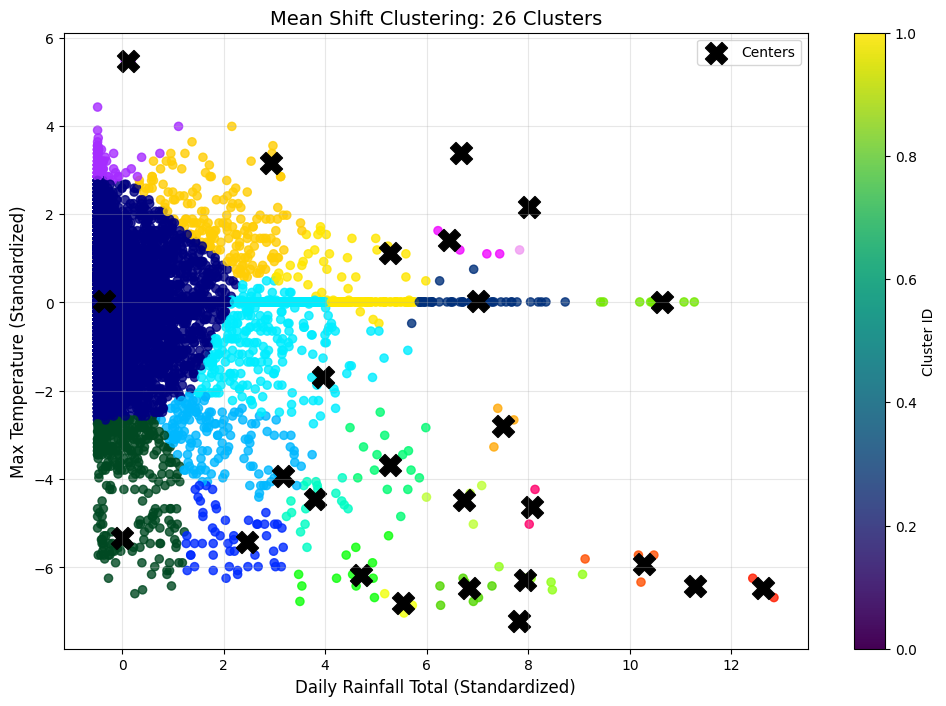

In [ ]:
plt.figure(figsize=(12, 8))

# Use a colormap that works well with many categories
scatter = plt.scatter(data_scaled[:, 0], data_scaled[:, 1],
                     c=cluster_labels,
                     cmap='gist_ncar',
                     s=35,
                     alpha=0.8)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           c='black',
           marker='X',
           s=250,
           label='Centers')

plt.xlabel('Daily Rainfall Total (Standardized)', fontsize=12)
plt.ylabel('Max Temperature (Standardized)', fontsize=12)
plt.title(f'Mean Shift Clustering: {n_clusters} Clusters', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sil_score = silhouette_score(data_scaled, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.547


In [ ]:
# Enhanced version with data types and unique values for student_df2
missing_report_student = pd.DataFrame({
    'column_name': student_df2.columns,
    'data_type': student_df2.dtypes.values,
    'total_values': len(student_df2),
    'missing_count': student_df2.isna().sum(),
    'missing_percentage': (student_df2.isna().sum() / len(student_df2)) * 100,
    'unique_values': student_df2.nunique()
})

# Round the percentage for readability
missing_report_student['missing_percentage'] = missing_report_student['missing_percentage'].round(2)

# Sort by missing percentage (descending)
missing_report_student = missing_report_student.sort_values('missing_percentage', ascending=False)

# Keep only columns with missing values
missing_report_student_missing = missing_report_student[missing_report_student['missing_count'] > 0]

if len(missing_report_student_missing) > 0:
    missing_report_student_missing.to_csv('missing_data_report_student.csv', index=False)
    print("Missing data report saved to 'missing_data_report_student.csv'")
    print("\nMissing values in student data:")
    print(missing_report_student_missing[['column_name', 'data_type', 'missing_count', 'missing_percentage', 'unique_values']].to_string(index=False))
else:
    print("No missing data found in student_df2!")

# Optional: Show complete overview including columns without missing values
print("\nComplete data overview:")
print(missing_report_student[['column_name', 'data_type', 'total_values', 'missing_count', 'missing_percentage', 'unique_values']].to_string(index=False))

No missing data found in student_df2!

Complete data overview:
                  column_name data_type  total_values  missing_count  missing_percentage  unique_values
                   student_id    object          1000              0                 0.0           1000
                          age   float64          1000              0                 0.0              8
                       gender     int64          1000              0                 0.0              3
          study_hours_per_day   float64          1000              0                 0.0             78
           social_media_hours   float64          1000              0                 0.0             60
                netflix_hours   float64          1000              0                 0.0             51
                part_time_job     int64          1000              0                 0.0              2
        attendance_percentage   float64          1000              0                 0.0            320
 

In [ ]:
# Create a clean copy first
student_clean = student_df2.dropna().copy()

# Then select your columns
selected_data2 = student_clean[['study_hours_per_day', 'exam_score']]

In [ ]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
student_scaled = scaler.fit_transform(selected_data2)

# data_scaled is now a NumPy array where each feature has a mean of 0 and a standard deviation of 1.
print("Mean after scaling:", student_scaled.mean(axis=0))
print("Std Dev after scaling:", student_scaled.std(axis=0))

Mean after scaling: [-1.77635684e-17 -7.63833441e-17]
Std Dev after scaling: [1. 1.]


In [ ]:
# Estimate bandwidth (the main parameter for Mean Shift)
bandwidth = estimate_bandwidth(student_scaled, quantile=0.1)  # Adjust quantile as needed (0.2 gives only 1 cluster)

# Create and fit the Mean Shift model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(student_scaled)

# Get the results
cluster_labels2 = ms.labels_
cluster_centers2 = ms.cluster_centers_
n_clusters2 = len(np.unique(cluster_labels2))

print(f"Number of clusters found: {n_clusters2}")


Number of clusters found: 3


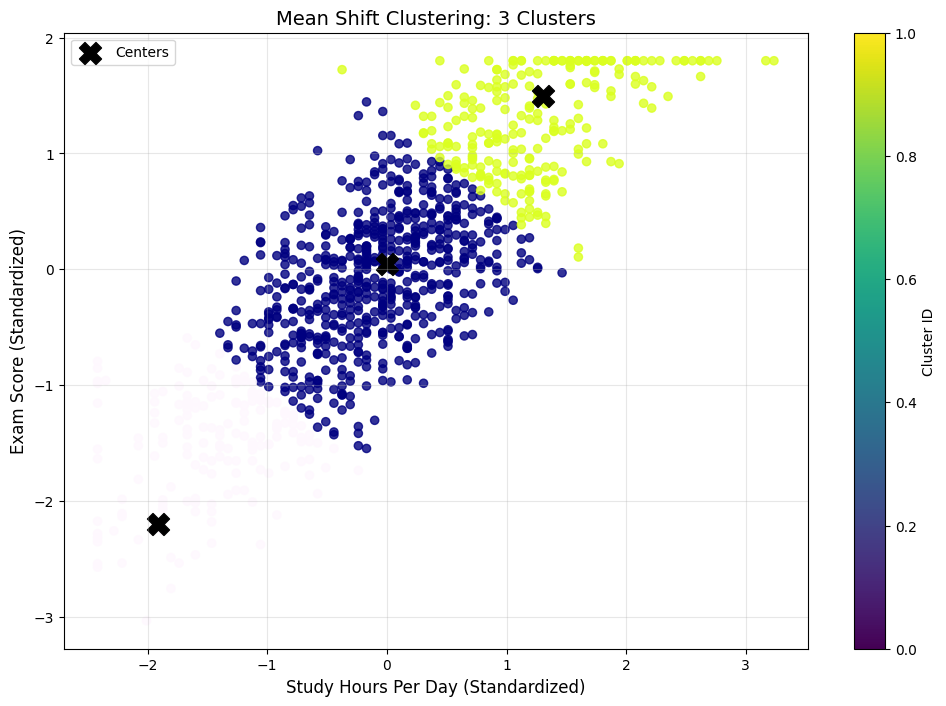

In [ ]:
selected_data2 = student_clean[['study_hours_per_day', 'exam_score']]
student_scaled = scaler.fit_transform(selected_data2)

plt.figure(figsize=(12, 8))

# Use a colormap that works well with many categories
scatter = plt.scatter(student_scaled[:, 0], student_scaled[:, 1],
                     c=cluster_labels2,
                     cmap='gist_ncar',
                     s=35,
                     alpha=0.8)

plt.scatter(cluster_centers2[:, 0], cluster_centers2[:, 1],
           c='black',
           marker='X',
           s=250,
           label='Centers')

# CORRECTED AXIS LABELS:
plt.xlabel('Study Hours Per Day (Standardized)', fontsize=12)
plt.ylabel('Exam Score (Standardized)', fontsize=12)
plt.title(f'Mean Shift Clustering: {n_clusters2} Clusters', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sil_score = silhouette_score(student_scaled, cluster_labels2)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.415


In [ ]:
# Higher Dimention performance evaluation
# remove student_id from features since it is not a feature that describes habits or performance.
student_all_features2 = student_df.drop(columns=['student_id'])

In [ ]:
# Estimate bandwidth automatically
bandwidth = estimate_bandwidth(student_all_features2, quantile=0.1)  # You can adjust quantile
print(f"Estimated bandwidth: {bandwidth}")

# Apply MeanShift
meanshift = MeanShift(bandwidth=bandwidth)
labels = meanshift.fit_predict(student_all_features2)

n_clusters2 = len(set(labels))
print(f"Estimated number of clusters: {n_clusters2}")

# Transform to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(student_all_features2)

student_all_features2["cluster"] = labels
print(student_all_features2['cluster'].value_counts().sort_index())

Estimated bandwidth: 6.16407143300852
Estimated number of clusters: 3
cluster
0    351
1    457
2    192
Name: count, dtype: int64


/tmp/ipython-input-2013077456.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


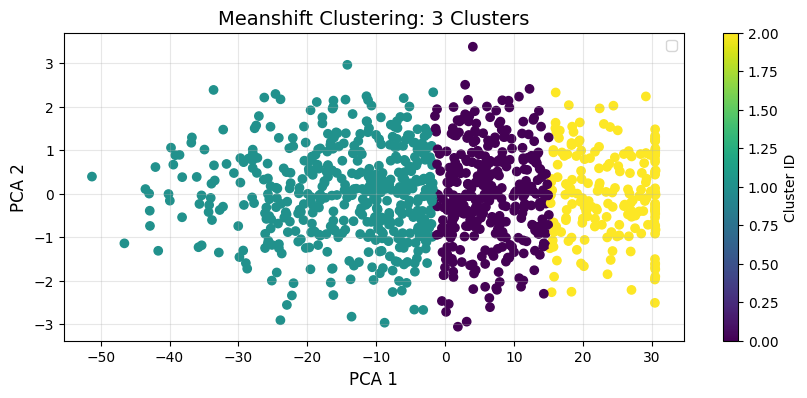

In [ ]:
# Plot the meanshift clustering with dimensionalilty reduction result
plt.figure(figsize=(10,4))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title(f'Meanshift Clustering: {n_clusters2} Clusters', fontsize=14)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)

plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## DBSCAN

In [ ]:
# DBSCAN on Weather Dataset
# 2D performance evaluation
weather_selected_features = weather_df.dropna()[['Daily_Rainfall_Total', 'Temp_Max']]

In [ ]:
# Determining MinPts(min_samples)
# General rule of thumb: choose MinPts = 2*dim (Sander et al., 1998)
MinPts = weather_selected_features.shape[1] * 2
print("Minimum number of data points:", MinPts)

Minimum number of data points: 4


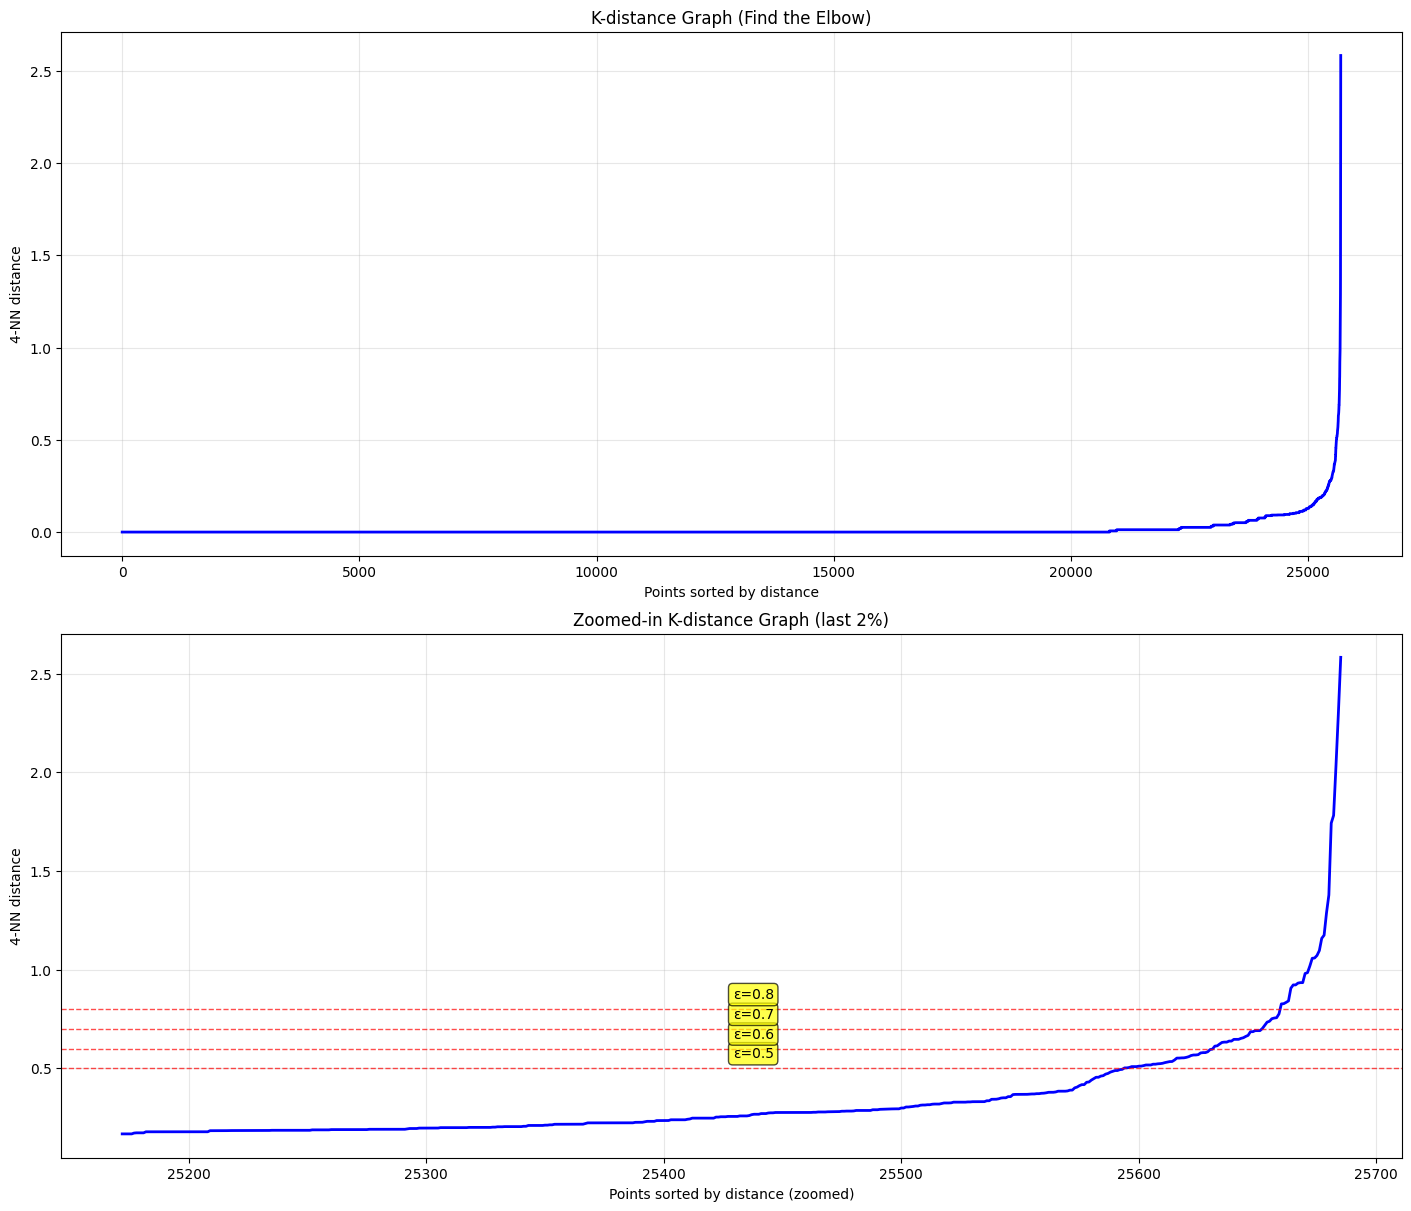

In [ ]:
# Determining Epsilon(eps)
# Use elbow method in K-distance graph

# Calculate the average distance between each point and its K nearest neighbours. Set K = MinPts
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(weather_selected_features)
distances, indices = neighbors_fit.kneighbors(weather_selected_features)

distances = np.sort(distances, axis=0)
distances = distances[:,MinPts-1]

# Create subplots with gridspec
fig, axes = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True)

# --- Main plot ---
axes[0].plot(distances, linewidth=2, color='blue')
axes[0].set_xlabel("Points sorted by distance")
axes[0].set_ylabel(f"{MinPts}-NN distance")
axes[0].set_title("K-distance Graph (Find the Elbow)")
axes[0].grid(True, alpha=0.3)

# --- Zoomed-in plot ---
zoom_start = int(len(distances) * 0.98)  # last 2%
axes[1].plot(range(zoom_start, len(distances)), distances[zoom_start:], linewidth=2, color='blue')
axes[1].set_xlabel("Points sorted by distance (zoomed)")
axes[1].set_ylabel(f"{MinPts}-NN distance")
axes[1].set_title("Zoomed-in K-distance Graph (last 2%)")
axes[1].grid(True, alpha=0.3)

# Add suggested epsilon lines
y_min_zoom, y_max_zoom = axes[1].get_ylim()
suggested_eps_values = [0.5, 0.6, 0.7, 0.8]
for eps_val in suggested_eps_values:
    if y_min_zoom <= eps_val <= y_max_zoom:
        axes[1].axhline(y=eps_val, color='red', linestyle='--', alpha=0.7, linewidth=1)
        axes[1].text(
            zoom_start + (len(distances) - zoom_start) * 0.5,
            eps_val + (y_max_zoom - y_min_zoom) * 0.02,
            f'ε={eps_val}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7)
        )

plt.show()

In [ ]:
# Apply DBSCAN, choose eps = 0.6
dbscan = DBSCAN(eps=0.6, min_samples=MinPts)
labels = dbscan.fit_predict(weather_selected_features[['Daily_Rainfall_Total', 'Temp_Max']])

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()
print(f"Estimated number of clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

weather_selected_features["cluster"] = labels
print(weather_selected_features['cluster'].value_counts().sort_index())

Estimated number of clusters: 9
Noise points: 27
cluster
-1       27
 0    25613
 1        8
 2       10
 3        5
 4        6
 5        5
 6        4
 7        4
 8        4
Name: count, dtype: int64


/tmp/ipython-input-1020677778.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


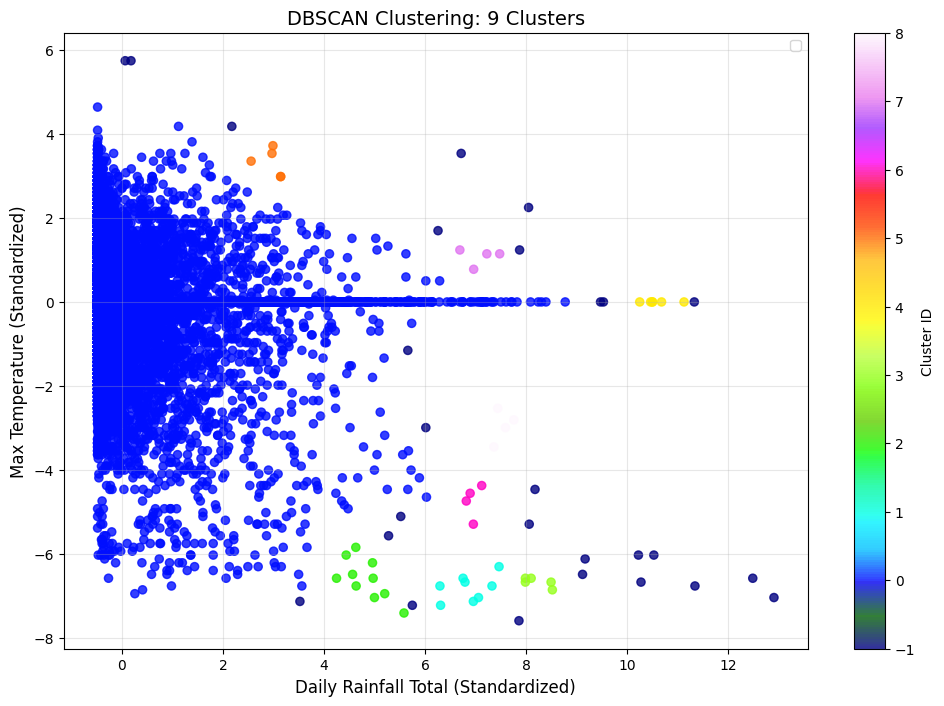

In [ ]:
#plot the DBSCAN clustering result
plt.figure(figsize=(12, 8))

scatter = plt.scatter(weather_selected_features['Daily_Rainfall_Total'], weather_selected_features['Temp_Max'],
                     c=labels,
                     cmap='gist_ncar',
                     s=35,
                     alpha=0.8)


plt.xlabel('Daily Rainfall Total (Standardized)', fontsize=12)
plt.ylabel('Max Temperature (Standardized)', fontsize=12)
plt.title(f'DBSCAN Clustering: {n_clusters} Clusters', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# DBSCAN on Student Dataset
# 2D performance evaluation
student_selected_features = student_df[['study_hours_per_day', 'exam_score']]


In [ ]:
# Determining MinPts(min_samples)
# General rule of thumb: choose MinPts = 2*dim (Sander et al., 1998)
MinPts = student_selected_features.shape[1] * 2
print("Minimum number of data points:", MinPts)

Minimum number of data points: 4


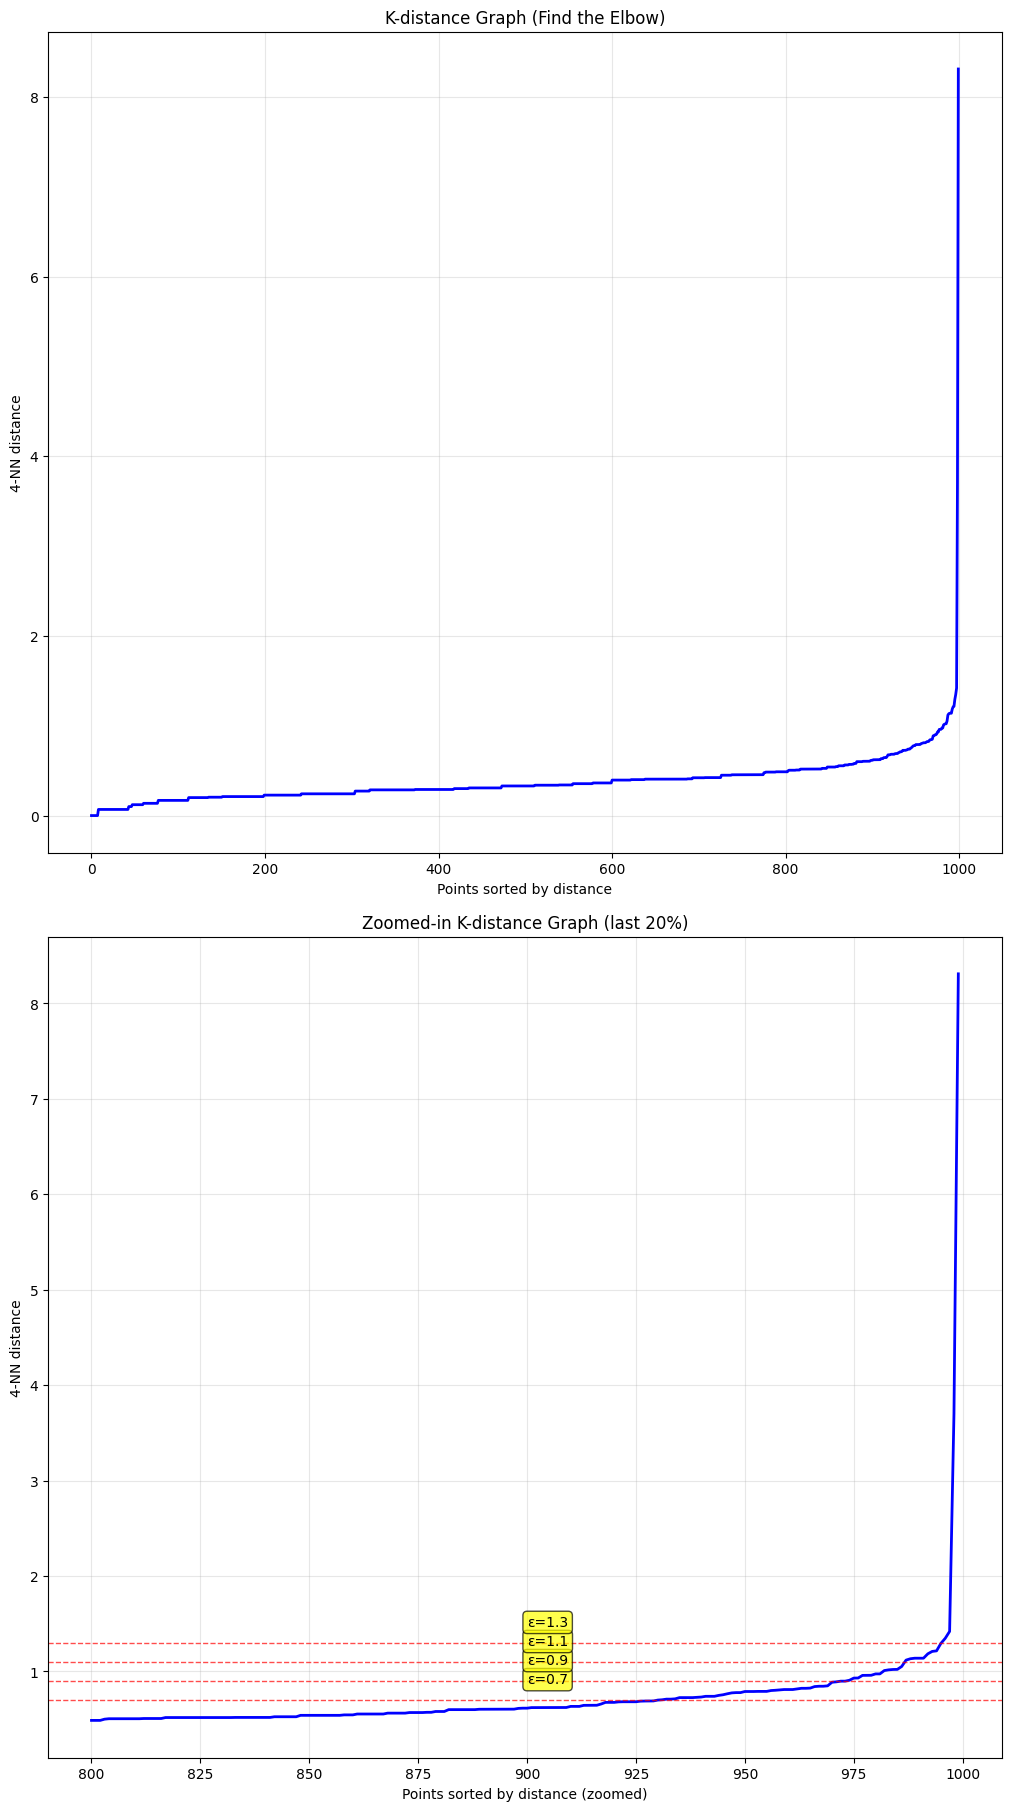

In [ ]:
# Determining Epsilon(eps)
# Use elbow method in K-distance graph

# Calculate the average distance between each point and its K nearest neighbours. Set K = MinPts
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(student_selected_features)
distances, indices = neighbors_fit.kneighbors(student_selected_features)

distances = np.sort(distances, axis=0)
distances = distances[:,MinPts-1]

# Create subplots with gridspec
fig, axes = plt.subplots(2, 1, figsize=(10, 18), constrained_layout=True)

# --- Main plot ---
axes[0].plot(distances, linewidth=2, color='blue')
axes[0].set_xlabel("Points sorted by distance")
axes[0].set_ylabel(f"{MinPts}-NN distance")
axes[0].set_title("K-distance Graph (Find the Elbow)")
axes[0].grid(True, alpha=0.3)

# --- Zoomed-in plot ---
zoom_start = int(len(distances) * 0.8)  # last 20%
axes[1].plot(range(zoom_start, len(distances)), distances[zoom_start:], linewidth=2, color='blue')
axes[1].set_xlabel("Points sorted by distance (zoomed)")
axes[1].set_ylabel(f"{MinPts}-NN distance")
axes[1].set_title("Zoomed-in K-distance Graph (last 20%)")
axes[1].grid(True, alpha=0.3)

# Add suggested epsilon lines
y_min_zoom, y_max_zoom = axes[1].get_ylim()
suggested_eps_values = [0.7, 0.9, 1.1, 1.3]
for eps_val in suggested_eps_values:
    if y_min_zoom <= eps_val <= y_max_zoom:
        axes[1].axhline(y=eps_val, color='red', linestyle='--', alpha=0.7, linewidth=1)
        axes[1].text(
            zoom_start + (len(distances) - zoom_start) * 0.5,
            eps_val + (y_max_zoom - y_min_zoom) * 0.02,
            f'ε={eps_val}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7)
        )

plt.show()

In [ ]:
# Apply DBSCAN, choose eps = 1.1
dbscan = DBSCAN(eps=1.1, min_samples=MinPts)
labels = dbscan.fit_predict(student_selected_features[['study_hours_per_day','exam_score']])

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()
print(f"Estimated number of clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

student_selected_features["cluster"] = labels
print(student_selected_features['cluster'].value_counts().sort_index())

Estimated number of clusters: 4
Noise points: 2
cluster
-1      2
 0    963
 1     21
 2      6
 3      8
Name: count, dtype: int64


/tmp/ipython-input-2563860397.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_selected_features["cluster"] = labels


/tmp/ipython-input-105153730.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


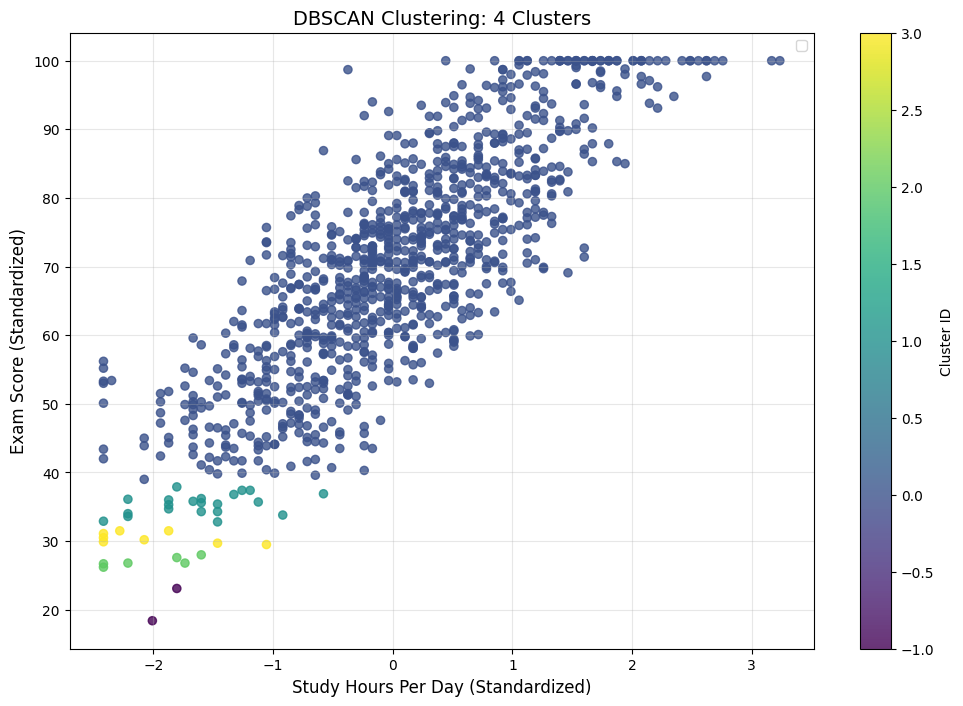

In [ ]:
#plot the DBSCAN clustering result
plt.figure(figsize=(12, 8))

scatter = plt.scatter(student_selected_features['study_hours_per_day'], student_selected_features['exam_score'],
                     c=labels,
                     s=35,
                     alpha=0.8)


plt.xlabel('Study Hours Per Day (Standardized)', fontsize=12)
plt.ylabel('Exam Score (Standardized)', fontsize=12)
plt.title(f'DBSCAN Clustering: {n_clusters} Clusters', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Higher Dimention performance evaluation
# remove student_id from features since it is not a feature that describes habits or performance.
student_all_features = student_df.drop(columns=['student_id'])

In [ ]:
MinPts = student_all_features.shape[1] * 2
print("Minimum number of data points:", MinPts)

Minimum number of data points: 30


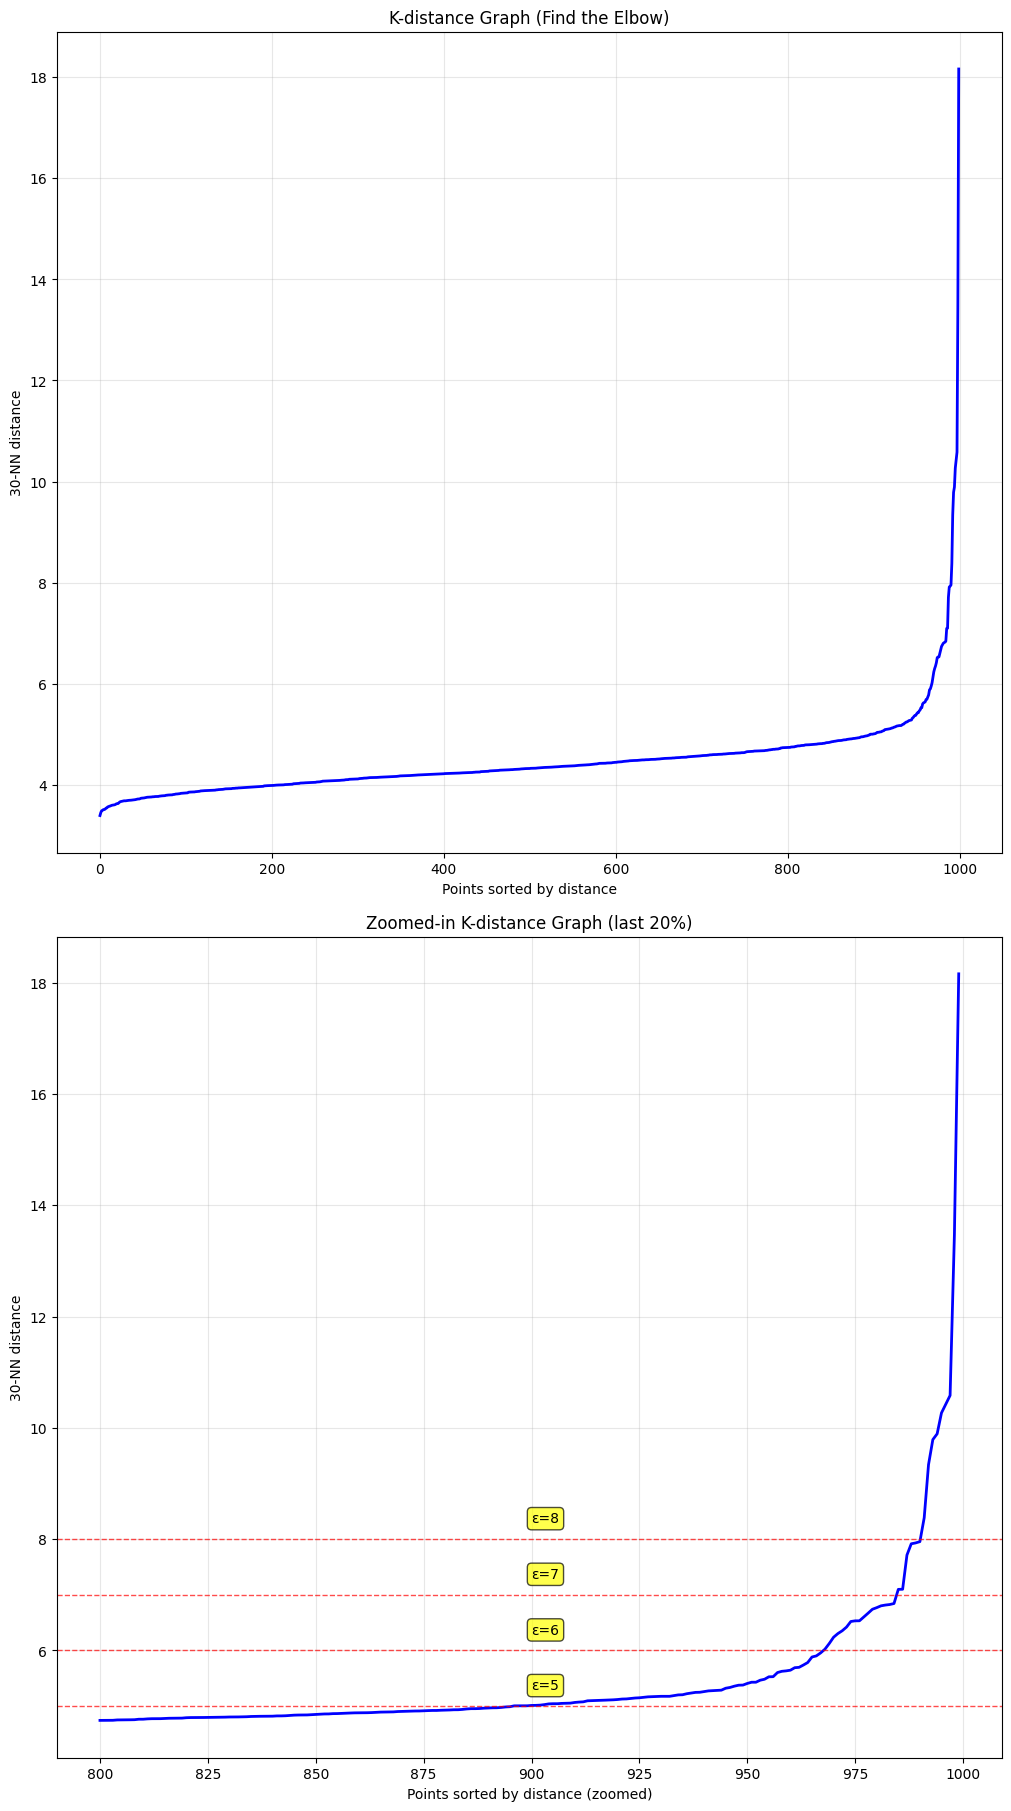

In [ ]:
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(student_all_features)
distances, indices = neighbors_fit.kneighbors(student_all_features)

distances = np.sort(distances, axis=0)
distances = distances[:,MinPts-1]

# Create subplots with gridspec
fig, axes = plt.subplots(2, 1, figsize=(10, 18), constrained_layout=True)

# --- Main plot ---
axes[0].plot(distances, linewidth=2, color='blue')
axes[0].set_xlabel("Points sorted by distance")
axes[0].set_ylabel(f"{MinPts}-NN distance")
axes[0].set_title("K-distance Graph (Find the Elbow)")
axes[0].grid(True, alpha=0.3)

# --- Zoomed-in plot ---
zoom_start = int(len(distances) * 0.8)  # last 20%
axes[1].plot(range(zoom_start, len(distances)), distances[zoom_start:], linewidth=2, color='blue')
axes[1].set_xlabel("Points sorted by distance (zoomed)")
axes[1].set_ylabel(f"{MinPts}-NN distance")
axes[1].set_title("Zoomed-in K-distance Graph (last 20%)")
axes[1].grid(True, alpha=0.3)

# Add suggested epsilon lines
y_min_zoom, y_max_zoom = axes[1].get_ylim()
suggested_eps_values = [5, 6, 7, 8]
for eps_val in suggested_eps_values:
    if y_min_zoom <= eps_val <= y_max_zoom:
        axes[1].axhline(y=eps_val, color='red', linestyle='--', alpha=0.7, linewidth=1)
        axes[1].text(
            zoom_start + (len(distances) - zoom_start) * 0.5,
            eps_val + (y_max_zoom - y_min_zoom) * 0.02,
            f'ε={eps_val}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7)
        )

plt.show()

In [ ]:
# Apply DBSCAN, choose eps = 6
dbscan = DBSCAN(eps=6, min_samples=MinPts)
labels = dbscan.fit_predict(student_all_features)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()
print(f"Estimated number of clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

# Transforms high-dimensional data into a lower-dimensional space (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(student_all_features)

student_all_features["cluster"] = labels
print(student_all_features['cluster'].value_counts().sort_index())

Estimated number of clusters: 1
Noise points: 16
cluster
-1     16
 0    984
Name: count, dtype: int64


/tmp/ipython-input-3284245318.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


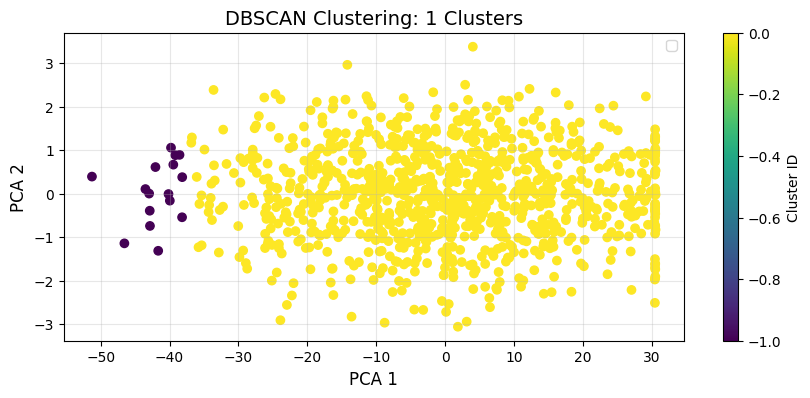

In [ ]:
# Plot the DBSCAN clustering with dimensionalilty reduction result
plt.figure(figsize=(10,4))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title(f'DBSCAN Clustering: {n_clusters} Clusters', fontsize=14)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)

plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


DBSCAN doest not perform well in high-dimensional spaces. This is because the distances between points become less meaningful, all points tend to be approximately equally distant from each other. As a result, DBSCAN often produces one huge cluster containing most of the data points.

In [ ]:
# Real-life application of DBSCAN - Outlier Detection
# DBSCAN on Covid Dataset
processed_data[DATASET_INFO[3].name] = (
        Data(DATASET_INFO[3].name)
        .read_raw_data(DATASET_INFO[3].drive_id))

covid_df = processed_data['covid'].data
covid_df

Downloading...
From: https://drive.google.com/uc?id=1tG_mw-ZiSN99JfOLDDcVn66nuCHnkpt9
To: /content/data/raw/covid.csv
100%|██████████| 15.4k/15.4k [00:00<00:00, 11.8MB/s]


case_id  latitude   longitude     case_type date_reported
0        204  1.306699  103.847571  active cases     17/5/2023
1        267  1.288643  103.852111  active cases     22/5/2023
2        153  1.286693  103.797751     new cases     23/5/2023
3         10  1.305593  103.893168  active cases     13/5/2023
4        234  1.326139  103.768698  active cases     22/5/2023
..       ...       ...         ...           ...           ...
325      326  1.379293  103.983912     new cases     22/5/2023
326      327  1.304425  103.683964  active cases     17/5/2023
327      328  1.319343  103.658215     new cases     12/5/2023
328      329  1.420647  103.708290     new cases     15/5/2023
329      330  1.420647  103.708290     new cases     18/5/2023

[330 rows x 5 columns]

In [ ]:
# Check for missing values
covid_df.isna().sum()

case_id          0
latitude         0
longitude        0
case_type        0
date_reported    0
dtype: int64

In [ ]:
# Plot Covid-19 cases before clustering
fig = px.scatter_map(
    covid_df,
    lat="latitude",
    lon="longitude",
    hover_name="case_id",
    hover_data=["case_type"],
    color_discrete_sequence=px.colors.qualitative.Set1,
    zoom=11,
    height=600
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Singapore COVID-19 Cases by Location")
fig.show()

In [ ]:
# Determining MinPts(min_samples)
# General rule of thumb: choose MinPts = 2*dim (Sander et al., 1998)
MinPts = 2
print("Minimum number of data points:", MinPts)

Minimum number of data points: 2


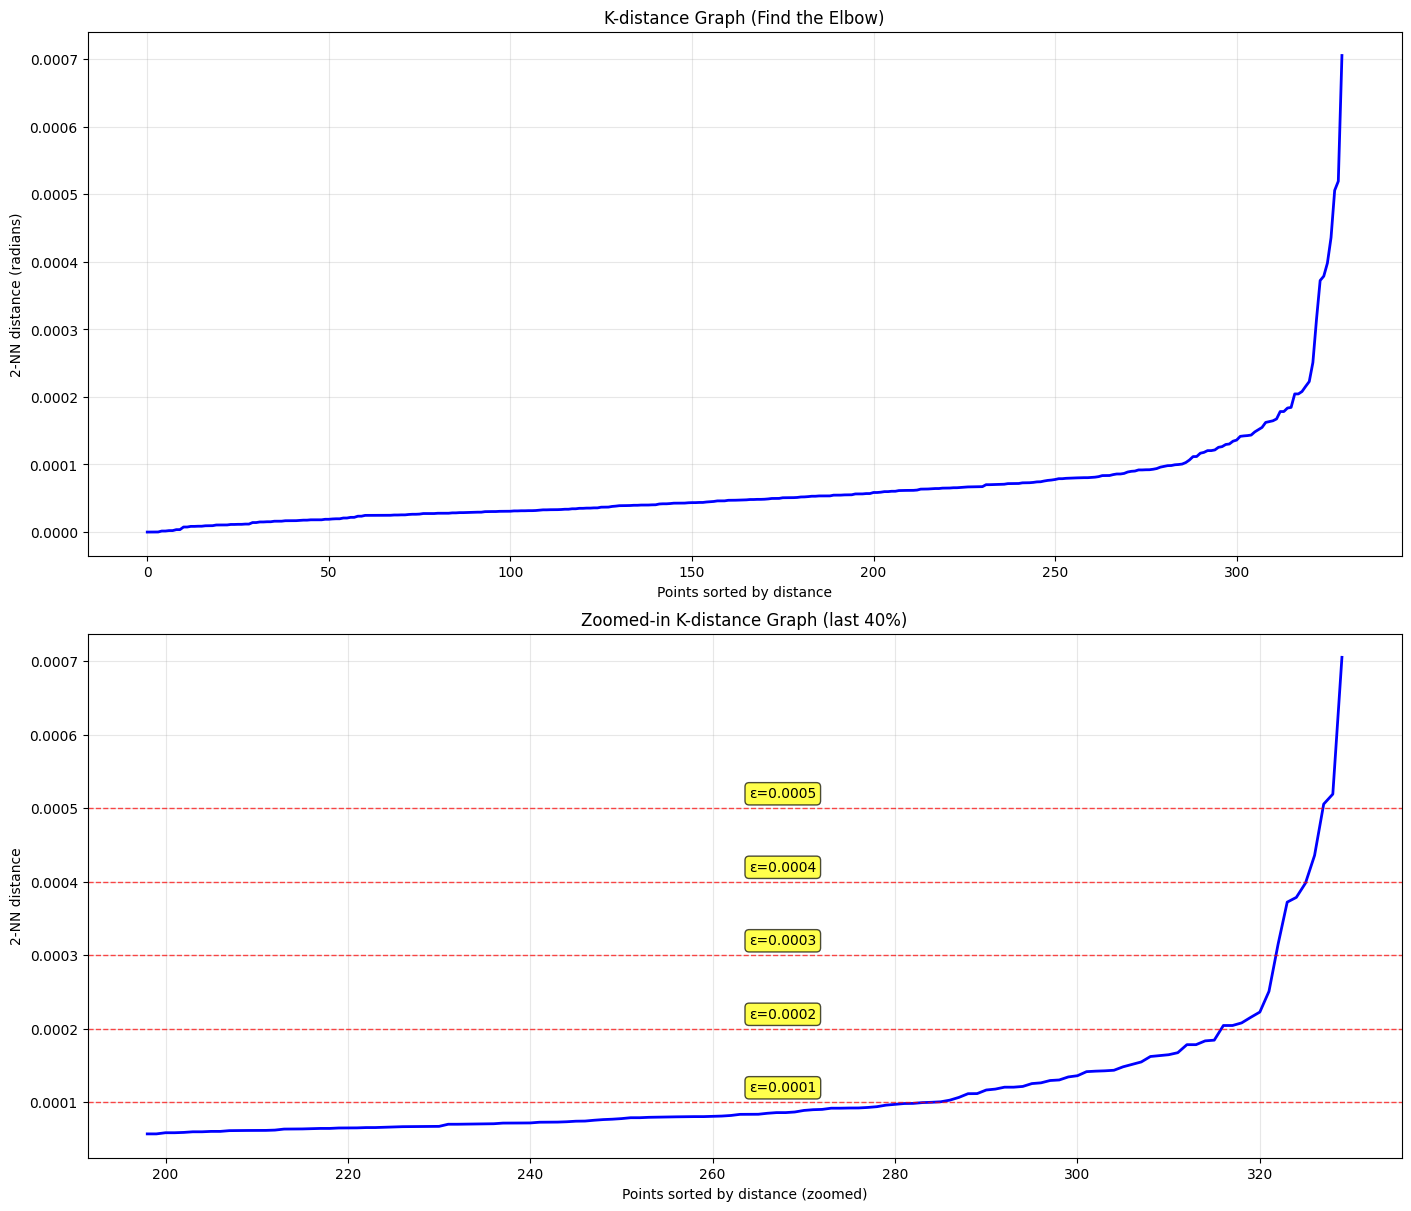

In [ ]:
# Determining Epsilon(eps)
# Use elbow method in K-distance graph

# Calculate the average distance between each point and its K nearest neighbours. Set K = MinPts

# Convert coordinates (latitude/longitude) to radians, because haversine distance metric requires coordinates in radians.
# Haversine distance metric accounts for the spherical nature of the Earth. Earth is not flat.
coords = np.radians(covid_df[['latitude', 'longitude']].values)
neighbors = NearestNeighbors(n_neighbors=MinPts, metric='haversine')

neighbors_fit = neighbors.fit(coords)
distances, indices = neighbors_fit.kneighbors(coords)

distances = np.sort(distances, axis=0)
distances = distances[:,MinPts-1]

# Create subplots with gridspec
fig, axes = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True)

# --- Main plot ---
axes[0].plot(distances, linewidth=2, color='blue')
axes[0].set_xlabel("Points sorted by distance")
axes[0].set_ylabel(f"{MinPts}-NN distance (radians)")
axes[0].set_title("K-distance Graph (Find the Elbow)")
axes[0].grid(True, alpha=0.3)

# --- Zoomed-in plot ---
zoom_start = int(len(distances) * 0.6)  # last 40%
axes[1].plot(range(zoom_start, len(distances)), distances[zoom_start:], linewidth=2, color='blue')
axes[1].set_xlabel("Points sorted by distance (zoomed)")
axes[1].set_ylabel(f"{MinPts}-NN distance")
axes[1].set_title("Zoomed-in K-distance Graph (last 40%)")
axes[1].grid(True, alpha=0.3)

# Add suggested epsilon lines
y_min_zoom, y_max_zoom = axes[1].get_ylim()
suggested_eps_values = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
for eps_val in suggested_eps_values:
    if y_min_zoom <= eps_val <= y_max_zoom:
        axes[1].axhline(y=eps_val, color='red', linestyle='--', alpha=0.7, linewidth=1)
        axes[1].text(
            zoom_start + (len(distances) - zoom_start) * 0.5,
            eps_val + (y_max_zoom - y_min_zoom) * 0.02,
            f'ε={eps_val}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7)
        )

plt.show()

In [ ]:
# Apply DBSCAN, choose eps = 0.0001
dbscan = DBSCAN(eps=0.0001, min_samples=MinPts)
labels = dbscan.fit_predict(coords)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()
print(f"Estimated number of clusters: {n_clusters}")
print(f"Noise points: {n_noise}")

covid_df["cluster"] = labels
covid_df = covid_df.sort_values(by="cluster")
print(covid_df['cluster'].value_counts().sort_index())
covid_df["cluster"] = covid_df["cluster"].astype(str)


Estimated number of clusters: 45
Noise points: 46
cluster
-1     46
 0     49
 1      2
 2      4
 3     17
 4     17
 5     16
 6     15
 7      2
 8      7
 9      5
 10    12
 11     2
 12     7
 13    12
 14     5
 15    10
 16     3
 17     7
 18    18
 19     2
 20     3
 21     2
 22     2
 23     2
 24     2
 25     4
 26     6
 27     3
 28     2
 29     3
 30     2
 31     2
 32     2
 33     2
 34     2
 35     2
 36     2
 37     4
 38     6
 39     5
 40     2
 41     4
 42     4
 43     2
 44     2
Name: count, dtype: int64


In [ ]:
# Plot Covid-19 cases after clustering, to detect outliers (Unlinked-cases)
fig = px.scatter_map(
    covid_df,
    lat="latitude",
    lon="longitude",
    hover_name="case_id",
    hover_data=["case_type", "cluster"],
    color="cluster",
    zoom=11,
    height=600
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Singapore COVID-19 Clusters by Location")
fig.show()

DBSCAN is particularly valuable for outlier detection in epidemiological studies. In the context of COVID-19 case clustering, outliers represent unlinked cases where the source of infection remains unknown.

Besides, DBSCAN's ability to identify clusters of arbitrary shape is crucial for modeling disease transmission patterns. Unlike algorithms like K-means that assume spherical clusters, DBSCAN can detect complex spatial patterns because diseases don't spread in uniform circular patterns.




## K-Means

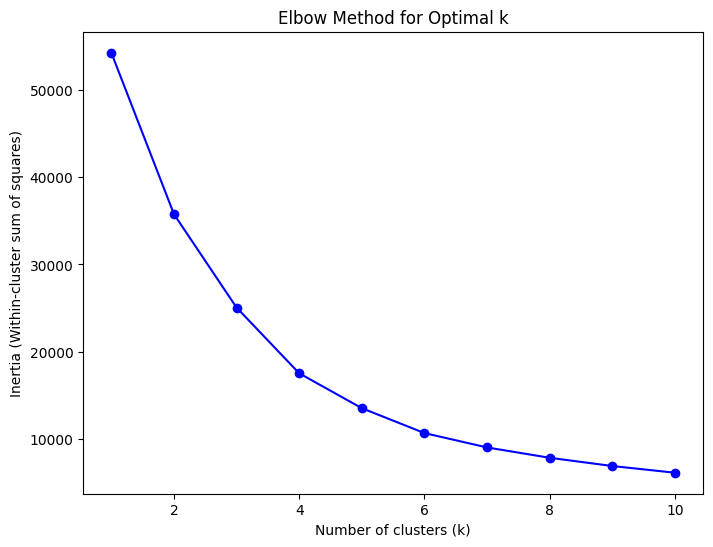

In [ ]:
df_sel = weather_df.dropna()[['Daily_Rainfall_Total', 'Temp_Max']]

# Elbow Method to find optimal k
inertias = []
K = range(1, 11)  # try k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sel)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

By using the elbow method, we can see that when no. of clusters > 4, the rate of change starts to slow down and the curve begins to flatten out. This will result in k = 4 being the most optimal value.

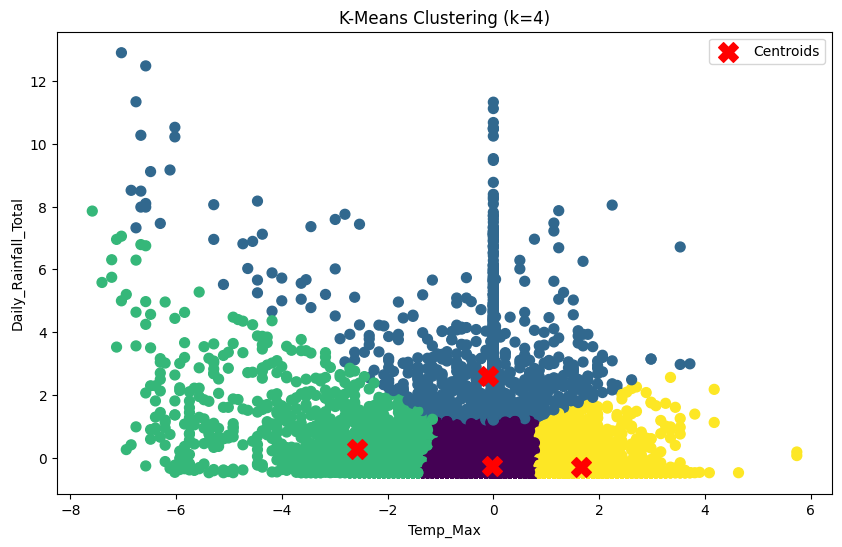

  Iterations until convergence: 8


In [ ]:
# Choose k based on elbow (k=4)
n = 4
kmeans = KMeans(n_clusters=n, random_state=42, n_init=600)
df_sel['Cluster'] = kmeans.fit_predict(df_sel)

# Plot final clustering with centroids
plt.figure(figsize=(10, 6))
plt.scatter(df_sel['Temp_Max'], df_sel['Daily_Rainfall_Total'],
            c=df_sel['Cluster'], cmap='viridis', s=50)

# Make sure centroids match x=Temp_Max, y=Rainfall
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0],
            c='red', marker='X', s=200, label='Centroids')

plt.xlabel("Temp_Max")
plt.ylabel("Daily_Rainfall_Total")
plt.title(f"K-Means Clustering (k={n})")
plt.legend()
plt.show()
print("  Iterations until convergence:", kmeans.n_iter_)

In the sample graph above, the K-Means algorithm identifies 4 clusters where all are aligned correctly to the centres. SKLearn uses KMeans++ which is smarter intialization than the traditional version.

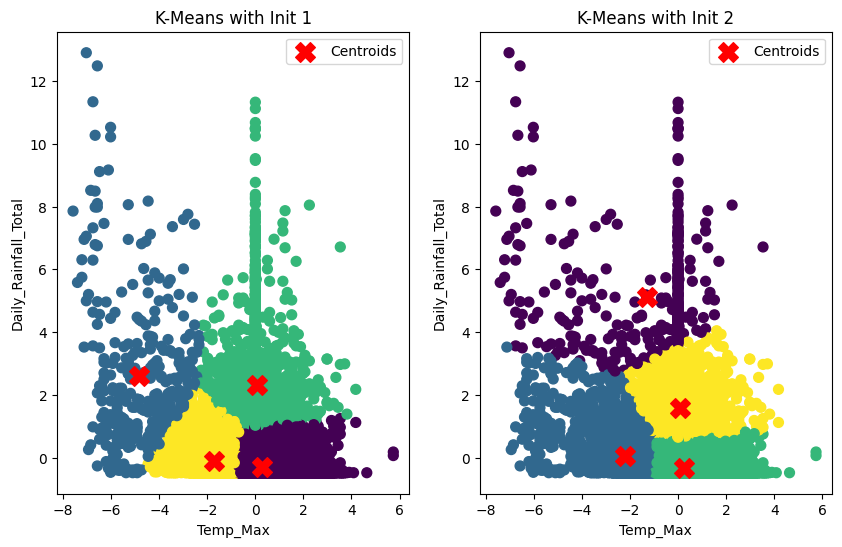

  Iterations until convergence (left fig): 17
  Iterations until convergence (right fig): 26


In [ ]:
df_sel = weather_df.dropna()[['Daily_Rainfall_Total', 'Temp_Max']]

# Force centroids to start in bad coordinates
init_centroids_1 = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0]
])

init_centroids_2 = np.array([
    [-8, 12],
    [-5, 12],
    [-1, 12],
    [8, 12]
])

# Fit KMeans with first init
kmeans1 = KMeans(n_clusters=4, init=init_centroids_1, n_init=1, random_state=42)
kmeans1.fit(df_sel)
df_clusters1 = df_sel.copy()
df_clusters1['Cluster'] = kmeans1.labels_

# Fit KMeans with second init
kmeans2 = KMeans(n_clusters=4, init=init_centroids_2, n_init=1, random_state=42)
kmeans2.fit(df_sel)
df_clusters2 = df_sel.copy()
df_clusters2['Cluster'] = kmeans2.labels_

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# First plot
axes[0].scatter(df_clusters1['Temp_Max'], df_clusters1['Daily_Rainfall_Total'],
                c=df_clusters1['Cluster'], cmap='viridis', s=50)
axes[0].scatter(kmeans1.cluster_centers_[:, 1], kmeans1.cluster_centers_[:, 0],
                c='red', marker='X', s=200, label='Centroids')
axes[0].set_xlabel("Temp_Max")
axes[0].set_ylabel("Daily_Rainfall_Total")
axes[0].set_title("K-Means with Init 1")
axes[0].legend()

# Second plot
axes[1].scatter(df_clusters2['Temp_Max'], df_clusters2['Daily_Rainfall_Total'],
                c=df_clusters2['Cluster'], cmap='viridis', s=50)
axes[1].scatter(kmeans2.cluster_centers_[:, 1], kmeans2.cluster_centers_[:, 0],
                c='red', marker='X', s=200, label='Centroids')
axes[1].set_xlabel("Temp_Max")
axes[1].set_ylabel("Daily_Rainfall_Total")
axes[1].set_title("K-Means with Init 2")
axes[1].legend()

plt.show()
print("  Iterations until convergence (left fig):", kmeans1.n_iter_)
print("  Iterations until convergence (right fig):", kmeans2.n_iter_)

In this example, we only changed the initial coordinates of the centroid and the cluster classification and no. of iterations is completely different.

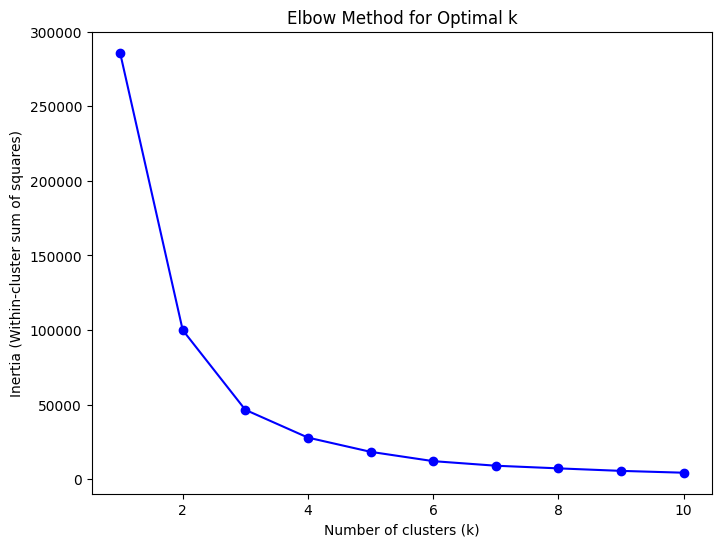

In [ ]:
df_sel = student_df.dropna()[['study_hours_per_day', 'exam_score']]

# Elbow Method to find optimal k
inertias = []
K = range(1, 11)  # try k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sel)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertias, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

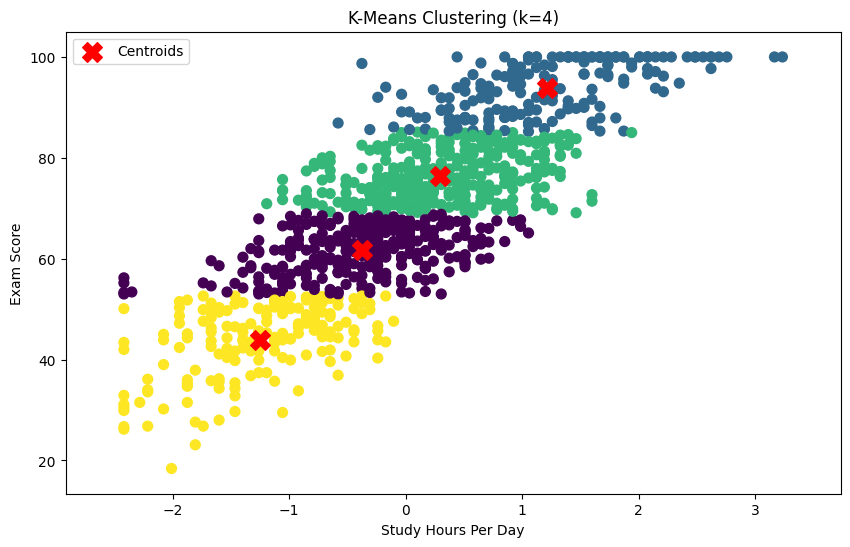

  Iterations until convergence: 4
Centroids:
 [[-3.74232278e-01  6.16906355e+01  9.10382880e-15]
 [ 1.21707596e+00  9.39141304e+01  1.00000000e+00]
 [ 2.96962424e-01  7.63455072e+01  2.00000000e+00]
 [-1.24708466e+00  4.38174419e+01  3.00000000e+00]]


In [ ]:
# Choose k based on elbow (k=4)
n = 4
kmeans = KMeans(n_clusters=n, random_state=42, n_init=60)
df_sel['Cluster'] = kmeans.fit_predict(df_sel)

# Plot final clustering with centroids
plt.figure(figsize=(10, 6))
plt.scatter(df_sel['study_hours_per_day'], df_sel['exam_score'],
            c=df_sel['Cluster'], cmap='viridis', s=50)

# Make sure centroids match x=Temp_Max, y=Rainfall
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200, label='Centroids')
#plt.xlim(0, 4)
#plt.ylim(50, 105)

plt.xlim(min(df_sel['study_hours_per_day'].min(), kmeans.cluster_centers_[:,0].min()) - 0.5,
         max(df_sel['study_hours_per_day'].max(), kmeans.cluster_centers_[:,0].max()) + 0.5)

plt.ylim(min(df_sel['exam_score'].min(), kmeans.cluster_centers_[:,1].min()) - 5,
         max(df_sel['exam_score'].max(), kmeans.cluster_centers_[:,1].max()) + 5)


plt.xlabel("Study Hours Per Day")
plt.ylabel("Exam Score")
plt.title(f"K-Means Clustering (k={n})")
plt.legend()
plt.show()
print("  Iterations until convergence:", kmeans.n_iter_)
print("Centroids:\n", kmeans.cluster_centers_)

# Cross-Algorithm Comparison

## Evaluation Framework

In [ ]:
class ClusteringMetric(Enum):
    SILHOUETTE = "Silhouette"
    DAVIES_BOULDIN = "Davies-Bouldin"
    CALINSKI_HARABASZ = "Calinski-Harabasz"
    DUNN = "Dunn"
    RUNTIME = "Runtime (s)"
    MEMORY = "Memory usage (MB)"
    NUM_CLUSTERS = "Number of Clusters"
    CLUSTER_STDDEV = "Cluster Size Standard Deviation"
    SMALLEST_CLUSTER = "Smallest Cluster"
    LARGEST_CLUSTER = "Largest Cluster"
    SEPARATION_RATIO = "Separation Ratio"
    LOF_SCORE = "LOF Mean Score"
    ISOLATION_FOREST_SCORE = "Isolation Forest Mean Score"
    SILHOUETTE_OUTLIER = "Silhouette Outlier Fraction"
    NOISE_FRACTION = "Noise Fraction"
    CORE_BORDER_RATIO = "Core Border Ratio"
    AVG_CORE_DISTANCE = "Average Core Distance"
    INERTIA = "Inertia"
    N_ITER = "Iterations Until Convergence"
    # SCALABILITY = "Scalability (Time by Fraction)"

UNIVERSAL_METRICS = [
    ClusteringMetric.SILHOUETTE,
    ClusteringMetric.DAVIES_BOULDIN,
    ClusteringMetric.CALINSKI_HARABASZ,
    ClusteringMetric.DUNN,
    ClusteringMetric.RUNTIME,
    ClusteringMetric.MEMORY,
    ClusteringMetric.NUM_CLUSTERS,
    ClusteringMetric.CLUSTER_STDDEV,
    ClusteringMetric.SMALLEST_CLUSTER,
    ClusteringMetric.LARGEST_CLUSTER,
    ClusteringMetric.SEPARATION_RATIO,
    ClusteringMetric.LOF_SCORE,
    ClusteringMetric.ISOLATION_FOREST_SCORE,
    ClusteringMetric.SILHOUETTE_OUTLIER,
]

In [ ]:
@dataclass
class MetricComputation:
    metric: ClusteringMetric
    func: Callable[[], Any]
    description: Optional[str] = None

def dunn_index(X, labels):
    clusters = [X[labels == i] for i in np.unique(labels)]
    intra = [cdist(c, c).max() for c in clusters if len(c) > 1]
    inter = [cdist(c1, c2).min()
             for i, c1 in enumerate(clusters)
             for c2 in clusters[i + 1:]]
    return np.min(inter) / np.max(intra) if intra and inter else np.nan

class MetricFactory:
    """
    Factory for generating a configurable list of clustering metric computations.

    Example:
        metrics = MetricFactory(lof_neighbors=50, iso_contamination=0.1).get_metrics()
    """

    def __init__(
        self,
        metrics: List[ClusteringMetric],
        lof_neighbors: int = 20,
        iso_contamination: float = 0.05,
        random_state: int = 42,
        enable_scalability: bool = False,
    ):
        self.metrics = metrics
        self.lof_neighbors = lof_neighbors
        self.iso_contamination = iso_contamination
        self.random_state = random_state
        self.enable_scalability = enable_scalability

    def get_metrics(self) -> List[MetricComputation]:
        """Return a list of MetricComputation objects configured with current parameters."""

        all_metrics = [
            # ---------- Cluster validity ----------
            MetricComputation(
                ClusteringMetric.SILHOUETTE,
                lambda X, labels, n_clusters, **kwargs:
                    silhouette_score(X, labels) if n_clusters > 1 else np.nan,
                "Silhouette score for cluster separation and cohesion."
            ),
            MetricComputation(
                ClusteringMetric.DAVIES_BOULDIN,
                lambda X, labels, n_clusters, **kwargs:
                    davies_bouldin_score(X, labels) if n_clusters > 1 else np.nan,
                "Davies-Bouldin index — lower is better."
            ),
            MetricComputation(
                ClusteringMetric.CALINSKI_HARABASZ,
                lambda X, labels, n_clusters, **kwargs: (
                    np.nan if n_clusters <= 1 else calinski_harabasz_score(X, labels) / len(X)
                ),
                "Normalized Calinski-Harabasz index — higher is better."
            ),
            MetricComputation(
                ClusteringMetric.DUNN,
                lambda X, labels, n_clusters, **kwargs:
                    dunn_index(X, labels) if n_clusters > 1 else np.nan,
                "Dunn index — higher indicates better cluster separation."
            ),

            # ---------- Cluster structure ----------
            MetricComputation(
                ClusteringMetric.CLUSTER_STDDEV,
                lambda X, labels, **kwargs: (
                    labels_pos := labels[labels != -1],
                    np.std(np.bincount(labels_pos)) if len(labels_pos) > 0 else np.nan
                )[-1],
                "Standard deviation of cluster sizes (ignoring noise)."
            ),
            MetricComputation(
                ClusteringMetric.SMALLEST_CLUSTER,
                lambda X, labels, **kwargs: (
                    labels_pos := labels[labels != -1],
                    np.min(np.bincount(labels_pos)) if len(labels_pos) > 0 else np.nan
                )[-1],
                "Size of the smallest cluster (ignoring noise)."
            ),
            MetricComputation(
                ClusteringMetric.LARGEST_CLUSTER,
                lambda X, labels, **kwargs: (
                    labels_pos := labels[labels != -1],
                    np.max(np.bincount(labels_pos)) if len(labels_pos) > 0 else np.nan
                )[-1],
                "Size of the largest cluster (ignoring noise)."
            ),

            # ---------- Separation ----------
            MetricComputation(
                ClusteringMetric.SEPARATION_RATIO,
                lambda X, labels, unique_labels, **kwargs: (
                    clusters := [i for i in unique_labels if i != -1],
                    intra := [cdist(X[labels == i], X[labels == i]).max() for i in clusters if np.sum(labels == i) > 1],
                    inter := [cdist(X[labels == clusters[i]], X[labels == clusters[j]]).min() for i in range(len(clusters)) for j in range(i + 1, len(clusters))],
                    np.mean(inter) / (np.mean(intra) + 1e-10) if intra and inter else np.nan
                )[-1],
                "Mean inter-cluster distance / intra-cluster distance ratio (ignoring noise points)."
            ),

            # ---------- Outlier metrics ----------
            MetricComputation(
                ClusteringMetric.LOF_SCORE,
                lambda X, labels, unique_labels, **kwargs: (
                    # Deduplicate rows
                    X_dedup := np.unique(X, axis=0),
                    # Align labels with deduplicated data
                    labels_aligned := labels[np.unique(X, axis=0, return_index=True)[1]],
                    # Fit LOF on deduplicated data
                    lof := LocalOutlierFactor(
                        n_neighbors=min(self.lof_neighbors, len(X_dedup) - 1)
                    ).fit(X_dedup),
                    scores := lof.negative_outlier_factor_,
                    # Compute cluster-weighted mean
                    np.mean([
                        np.mean(scores[labels_aligned == label])
                        for label in np.unique(labels_aligned)
                        if np.sum(labels_aligned == label) > 1
                    ])
                )[-1],  # return the last element: the actual metric value
                f"Mean cluster-weighted Local Outlier Factor score (deduplicated, n_neighbors={self.lof_neighbors})."
            ),
            MetricComputation(
                ClusteringMetric.ISOLATION_FOREST_SCORE,
                lambda X, labels, unique_labels, **kwargs: (
                    lambda iso, scores: np.mean([
                        np.mean(scores[labels == label])
                        for label in unique_labels
                    ])
                )(
                    # Fit IsolationForest on a sample to speed up
                    iso := IsolationForest(
                        contamination=self.iso_contamination,
                        random_state=self.random_state,
                        n_estimators=100
                    ).fit(X[np.random.choice(len(X), min(5000, len(X)), replace=False)]),

                    # Compute anomaly scores on full dataset
                    scores := -IsolationForest(
                        contamination=self.iso_contamination,
                        random_state=self.random_state,
                        n_estimators=100
                    ).fit(X[np.random.choice(len(X), min(5000, len(X)), replace=False)]).decision_function(X)
                ),
                "Mean Isolation Forest anomaly score aggregated over clusters (cluster-weighted, sampled)."
            ),
            MetricComputation(
                ClusteringMetric.SILHOUETTE_OUTLIER,
                lambda X, labels, n_clusters, **kwargs:
                    np.mean(silhouette_samples(X, labels) < 0) if n_clusters > 1 else np.nan,
                "Fraction of samples with negative silhouette values."
            ),
            MetricComputation(
                ClusteringMetric.NOISE_FRACTION,
                lambda X, labels, **kwargs:
                    np.mean(labels == -1),
                "Fraction of points labeled as noise by DBSCAN."
            ),
            MetricComputation(
                ClusteringMetric.CORE_BORDER_RATIO,
                lambda X, labels, eps, min_samples, **kwargs: (
                    neighbors := NearestNeighbors(radius=eps).fit(X),
                    counts := np.array([len(neighbors.radius_neighbors([x], return_distance=False)[0]) for x in X]),
                    core_mask := counts >= min_samples,
                    np.sum(core_mask) / (np.sum(labels != -1) + 1e-10)
                )[-1],
                "Ratio of core points to total clustered (non-noise) points."
            ),
            MetricComputation(
                ClusteringMetric.AVG_CORE_DISTANCE,
                lambda X, labels, eps, **kwargs:
                    np.mean([
                        np.mean(cdist(X[labels == i], X[labels == i]))
                        for i in np.unique(labels)
                        if i != -1 and np.sum(labels == i) > 1
                    ]),
                "Average pairwise distance within core clusters (smaller = denser clusters)."
            ),

            # ---------- KMeans metrics ----------
            MetricComputation(
                ClusteringMetric.INERTIA,
                lambda X, labels, n_clusters, **kwargs: getattr(kwargs.get('model', None), 'inertia_', np.nan),
                "Within-cluster sum of squares (K-Means inertia)."
            ),
            MetricComputation(
                ClusteringMetric.N_ITER,
                lambda X, labels, n_clusters, **kwargs: getattr(kwargs.get('model', None), 'n_iter_', np.nan),
                "Iterations until K-Means convergence."
            ),
        ]

        # if self.enable_scalability:
        #     metrics.append(
        #         MetricComputation(
        #             ClusteringMetric.SCALABILITY,
        #             lambda X, fit_func, fractions_for_scalability=[0.2, 0.4, 0.6, 0.8, 1.0], **kwargs: (
        #                 lambda X_sizes, runtimes: LinearRegression().fit(X_sizes, runtimes).coef_[0]
        #             )(
        #                 X_sizes=np.array([len(X) * frac for frac in fractions_for_scalability]).reshape(-1, 1),
        #                 runtimes=np.array([
        #                     (lambda start=time.time(): (fit_func(X[:int(len(X) * frac)]), time.time() - start)[1])()
        #                     for frac in fractions_for_scalability
        #                 ])
        #             ),
        #             "Slope of runtime vs dataset size: lower slope = better scalability."
        #         )
        #     )

        return [m for m in all_metrics if m.metric in self.metrics]

In [ ]:
@dataclass
class PlotGroup:
    subplot_title: Optional[str]
    metrics: List[ClusteringMetric]
    normalize: bool

class PlotFactory:
    def __init__(self, metrics: List[ClusteringMetric]):
        self.metrics = metrics

    def get_plots(self) -> Dict[str, List[PlotGroup]]:
        plot_groups: Dict[str, List[PlotGroup]] = {}

        # Define all possible plot groups
        all_plot_groups = {
            "Cluster Quality Scores": [
                PlotGroup(
                    subplot_title=None,
                    metrics=[ClusteringMetric.SILHOUETTE, ClusteringMetric.DAVIES_BOULDIN,
                             ClusteringMetric.CALINSKI_HARABASZ, ClusteringMetric.DUNN],
                    normalize=True,
                ),
            ],
            "Performance": [
                PlotGroup(
                    subplot_title="Runtime (ms)",
                    metrics=[ClusteringMetric.RUNTIME],
                    normalize=False,
                ),
                PlotGroup(
                    subplot_title="Memory (MB)",
                    metrics=[ClusteringMetric.MEMORY],
                    normalize=False,
                ),
                PlotGroup(
                    subplot_title="K-Means Specific",
                    metrics=[ClusteringMetric.INERTIA, ClusteringMetric.N_ITER],
                    normalize=False,
                ),
            ],
            "Cluster Sizes": [
                PlotGroup(
                    subplot_title="Cluster Standard Deviation",
                    metrics=[ClusteringMetric.CLUSTER_STDDEV],
                    normalize=False,
                ),
                PlotGroup(
                    subplot_title="Cluster Sizes",
                    metrics=[ClusteringMetric.SMALLEST_CLUSTER, ClusteringMetric.LARGEST_CLUSTER],
                    normalize=False,
                ),
                PlotGroup(
                    subplot_title="Separation Ratio",
                    metrics=[ClusteringMetric.SEPARATION_RATIO],
                    normalize=False,
                ),
            ],
            "Outlier Scores": [
                PlotGroup(
                    subplot_title=None,
                    metrics=[ClusteringMetric.LOF_SCORE, ClusteringMetric.ISOLATION_FOREST_SCORE,
                             ClusteringMetric.SILHOUETTE_OUTLIER],
                    normalize=True,
                ),
            ],
            "DBSCAN Density Diagnostics": [
                PlotGroup(
                    subplot_title=None,
                    metrics=[
                        ClusteringMetric.NOISE_FRACTION,
                        ClusteringMetric.CORE_BORDER_RATIO,
                        ClusteringMetric.AVG_CORE_DISTANCE
                    ],
                    normalize=True,
                ),
            ],
        }

        # Filter plot groups based on intersection with self.metrics
        for group_name, group_list in all_plot_groups.items():
            filtered_group = []
            for pg in group_list:
                intersecting_metrics = list(set(pg.metrics) & set(self.metrics))
                if intersecting_metrics:
                    filtered_group.append(
                        PlotGroup(
                            subplot_title=pg.subplot_title,
                            metrics=intersecting_metrics,
                            normalize=pg.normalize
                        )
                    )
            if filtered_group:
                plot_groups[group_name] = filtered_group

        return plot_groups

In [ ]:
class ClusteringFramework(ABC):
    def __init__(self, data, metrics, param_grid, plot_groups):
        self.data = data
        self.metrics = metrics
        self.param_grid = param_grid
        self.plot_groups = plot_groups
        self.model = None
        self.labels = None

        self.scores_df = pd.DataFrame()
        self.results_df = pd.DataFrame()

    # ---------------------------
    # Abstract methods
    # ---------------------------
    @abstractmethod
    def fit(self, X) -> Tuple[Any, Dict]:
        pass

    @abstractmethod
    def reset_model(self):
        pass

    def evaluate_model(self):
        self.preprocess()
        self.reset_dfs()
        self.run_param_sweep()
        self.plot_clusters()
        self.plot_param_metrics()
        self.show_results_table()

    def preprocess(self):
        df = self.data.dropna().copy()
        df = df.select_dtypes(include=[np.number])

        X_scaled = StandardScaler().fit_transform(df)
        print(f"✅ Scaled {df.shape[0]} rows × {df.shape[1]} features")

        self.data = X_scaled
        return X_scaled

    def reset_dfs(self):
        all_columns = set()
        param_columns = set(self.param_grid.keys())

        for group_list in self.plot_groups.values():
            for group in group_list:
                for metric in group.metrics:
                    all_columns.add(metric.value)

        self.scores_df = pd.DataFrame(columns=['param'] + list(param_columns) + list(all_columns))
        self.results_df = pd.DataFrame()

    def run_param_sweep(self):
        if self.data is None:
            raise ValueError("Please run preprocess() before calling this method.")

        X = self.data
        if isinstance(X, pd.DataFrame):
            X = X.select_dtypes(include=[np.number]).values

        for param, values in self.param_grid.items():
            values = list(values)
            self.reset_model()

            pbar = tqdm(values, desc=f"{param} values", leave=True, unit="val")
            for val in pbar:
                setattr(self, param, val)

                previously_computed = False
                for df_attr in ["scores_df", "results_df"]:
                        df = getattr(self, df_attr, None)
                        if df is None or not isinstance(df, pd.DataFrame):
                            continue

                        mask = np.ones(len(df), dtype=bool)
                        for p in self.param_grid.keys():
                            if p in df.columns:
                                mask &= df[p] == getattr(self, p)
                            else:
                                mask &= False

                        existing_rows = df[mask]
                        if not existing_rows.empty:
                            new_row = existing_rows.iloc[0].copy()
                            for p in self.param_grid.keys():
                                new_row[p] = getattr(self, p)
                            new_row["param"] = param
                            setattr(self, df_attr, pd.concat([df, pd.DataFrame([new_row])], ignore_index=True))
                            previously_computed = True

                if previously_computed:
                    pbar.set_postfix({"status": "skipped"})
                    continue

                try:
                    start_time = time.time()
                    mem_timeline, fit_output = memory_usage((lambda: self.fit(X),), interval=0.01, retval=True)
                    end_time = time.time()
                    total_memory = sum(mem_timeline) * 0.01
                    labels, results = fit_output
                    self.labels = labels

                    results['param'] = param
                    results[param] = val
                    results['labels'] = labels
                    self.results_df = pd.concat([self.results_df, pd.DataFrame([results])], ignore_index=True)

                    scores = self.evaluate(X)
                    scores[ClusteringMetric.RUNTIME.value] = round(end_time - start_time, 4)
                    scores[ClusteringMetric.MEMORY.value] = round(total_memory, 4)

                    row = {**{p: getattr(self, p) for p in self.param_grid.keys() if hasattr(self, p)}, param: val}
                    row['param'] = param
                    row[param] = val

                    for metric_name, score in scores.items():
                        if metric_name in self.scores_df.columns:
                            row[metric_name] = score

                    self.scores_df.loc[len(self.scores_df)] = row

                    pbar.set_postfix({
                        "status": "done",
                        "runtime_s": f"{end_time - start_time:.2f}",
                        "memory_MB": f"{total_memory:.2f}",
                        "n_clusters": len(np.unique(labels)),
                        "silhouette": f"{scores.get(ClusteringMetric.SILHOUETTE.value, np.nan):.3f}"
                    })
                except Exception as e:
                    pbar.set_postfix({"status": "failed", "error": str(e)})
                    continue

    def plot_param_metrics(self):
        for param, values in self.param_grid.items():
            if param not in self.scores_df.columns:
                continue

            for group_name, group_list in self.plot_groups.items():
                n_subplots = len(group_list)
                fig = make_subplots(
                    rows=n_subplots, cols=1, shared_xaxes=False,
                    subplot_titles=[
                        g.subplot_title if g.subplot_title else
                        " | ".join([m.value for m in g.metrics])
                        for g in group_list
                    ]
                )

                colors = qualitative.Plotly
                trace_idx = 0
                scores_df = self.scores_df[self.scores_df['param'] == param]

                for row_idx, group in enumerate(group_list, start=1):
                    for metric in group.metrics:
                        if metric.value not in scores_df.columns:
                            continue
                        y = scores_df[metric.value].values.astype(float)

                        if group.normalize and not np.all(np.isnan(y)):
                            y_min, y_max = np.nanmin(y), np.nanmax(y)
                            if y_max - y_min > 0:
                                y = 2 * (y - y_min) / (y_max - y_min) - 1

                        color = colors[trace_idx % len(colors)]
                        fig.add_trace(
                            go.Scatter(
                                x=scores_df[param].values,
                                y=y,
                                mode="lines+markers+text",
                                name=metric.value,
                                line=dict(color=color),
                                text=[f"{v:.3f}" if not np.isnan(v) else "" for v in y],
                                textposition="top center",
                                textfont=dict(color=color),
                                hovertemplate=f"<b>{param}=%{{x}}</b><br>{metric.value}: %{{y:.3f}}<extra></extra>"
                            ),
                            row=row_idx, col=1
                        )
                        trace_idx += 1

                fig.update_layout(
                    height=max(500 * n_subplots, 600),
                    width=1200,
                    title=f"{group_name} vs {param}",
                    template="plotly_white",
                    showlegend=True,
                    margin=dict(t=100, r=200)
                )


                for i in range(1, n_subplots + 1):
                    fig.update_xaxes(tickmode='array', tickvals=list(values), row=i, col=1)

                fig.show()

    def show_results_table(self):
        app = Dash(__name__)

        app.layout = html.Div([
            html.H2("📊 All Parameter Scores", style={'textAlign': 'center'}),
            html.Div(
                dash_table.DataTable(
                    id='results-table',
                    columns=[
                        {
                            "name": col,
                            "id": col,
                            "type": "numeric" if pd.api.types.is_numeric_dtype(self.scores_df[col]) else "text",
                            "presentation": "input"
                        }
                        for col in self.scores_df.columns
                    ],
                    data=self.scores_df.to_dict('records'),
                    filter_action="native",
                    sort_action="native",
                    page_action="native",
                    page_size=15,
                    style_table={'overflowX': 'auto', 'maxHeight': '700px'},
                    style_cell={'textAlign': 'center', 'padding': '8px'},
                    style_header={
                        'backgroundColor': '#0074D9',
                        'color': 'white',
                        'fontWeight': 'bold'
                    }
                ),
                style={'margin': '20px'}
            ),
            html.Div(
                html.A(
                    "⬇️ Download CSV",
                    href="data:text/csv;charset=utf-8," + self.scores_df.to_csv(index=False),
                    download="results.csv",
                    style={
                        "backgroundColor": "#0074D9",
                        "color": "white",
                        "padding": "10px 15px",
                        "borderRadius": "8px",
                        "textDecoration": "none",
                        "fontWeight": "bold",
                        "display": "inline-block",
                        "marginBottom": "20px"
                    }
                ),
                style={'textAlign': 'center'}
            )
        ])

        app.run(mode='inline', port=8050)

    # ---------------------------
    # Evaluation
    # ---------------------------
    def evaluate(self, X):
        results = {}
        for metric in self.metrics:
            try:
                score = metric.func(**self.get_evaluate_metrics(X))
            except Exception:
                score = np.nan
            results[metric.metric.value] = score

        return results

    def get_evaluate_metrics(self, X) -> dict:
        n_clusters = len(np.unique(self.labels))
        unique_labels = np.unique(self.labels)

        common_kwargs = {
            'X': X,
            'labels': self.labels,
            'n_clusters': n_clusters,
            'unique_labels': unique_labels,
            'fit_func': self.fit,
            'model': self.model,
        }

        for param_name in self.param_grid.keys():
            common_kwargs[param_name] = getattr(self, param_name, None)

        return common_kwargs

    # ---------------------------
    # Plotting clusters (reusable)
    # ---------------------------
    def plot_clusters(self, show_centers=True):
        if self.results_df.empty:
            print("No clustering results to plot.")
            return

        n = len(self.results_df)
        ncols = 3
        nrows = math.ceil(n / ncols)

        pca = PCA(n_components=2)
        reduced = pca.fit_transform(self.data)

        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
        axes = axes.flatten()

        for i, (_, row) in enumerate(self.results_df.iterrows()):
            ax = axes[i]
            labels = row["labels"]
            param = row["param"]
            val = row[param]

            scatter = ax.scatter(
                reduced[:, 0], reduced[:, 1],
                c=labels,
                cmap="tab10",  # <- darker, distinct colors
                s=50,          # slightly bigger points
                alpha=0.9,
                edgecolor='k', # black edges for better separation
                linewidth=0.5
            )
            ax.set_title(f"{param} = {val}", fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor("white")  # ensure white background

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Cluster Plots for All Parameter Configurations", fontsize=16)
        plt.tight_layout()
        plt.show()

## (1) Means Shift

In [ ]:
class MeanShiftFramework(ClusteringFramework):
    def __init__(self, data, metrics, param_grid, plot_groups, quantile=0.1, bin_seeding=True):
        super().__init__(data, metrics, param_grid, plot_groups)
        self.quantile = quantile
        self._quantile = quantile
        self.bin_seeding = bin_seeding
        self._bin_seeding = bin_seeding
        self.cluster_centers = None
        self.reset_model()  # initialize model

    # --- Fit MeanShift ---
    def fit(self, X=None) -> Tuple[np.ndarray, dict]:
        if X is None:
            X = self.data
        if X is None:
            raise ValueError("No data available. Please run preprocess() first.")

        # Fit MeanShift
        bandwidth = self.estimate_bandwidth(X)
        self.model = MeanShift(bandwidth=bandwidth, bin_seeding=self.bin_seeding)
        self.model.fit(X)

        self.labels = self.model.labels_
        self.cluster_centers = self.model.cluster_centers_

        # Compute metrics
        results = self.evaluate(X)

        # Include parameter values
        param_values = {k: getattr(self, k) for k in self.param_grid.keys() if hasattr(self, k)}
        results.update(param_values)

        return self.labels, results

    # --- Reset model ---
    def reset_model(self):
        """
        Reinitialize the MeanShift model with current parameters.
        """
        X = self.data
        self.bin_seeding = self._bin_seeding
        self.quantile = self._quantile
        bandwidth = None
        if X is not None and len(X) > 0:
            try:
                bandwidth = self.estimate_bandwidth(X)
            except Exception:
                bandwidth = None

        self.model = MeanShift(bandwidth=bandwidth, bin_seeding=self.bin_seeding)
        self.cluster_centers = None

    def estimate_bandwidth(self, X):
        subset = X[np.random.choice(len(X), min(2000, len(X)), replace=False)]
        return estimate_bandwidth(subset, quantile=self.quantile)

✅ Scaled 1000 rows × 2 features


bin_seeding values: 100%|██████████| 2/2 [00:22<00:00, 11.38s/val, status=done, runtime_s=22.21, memory_MB=7576.61, n_clusters=3, silhouette=0.416]


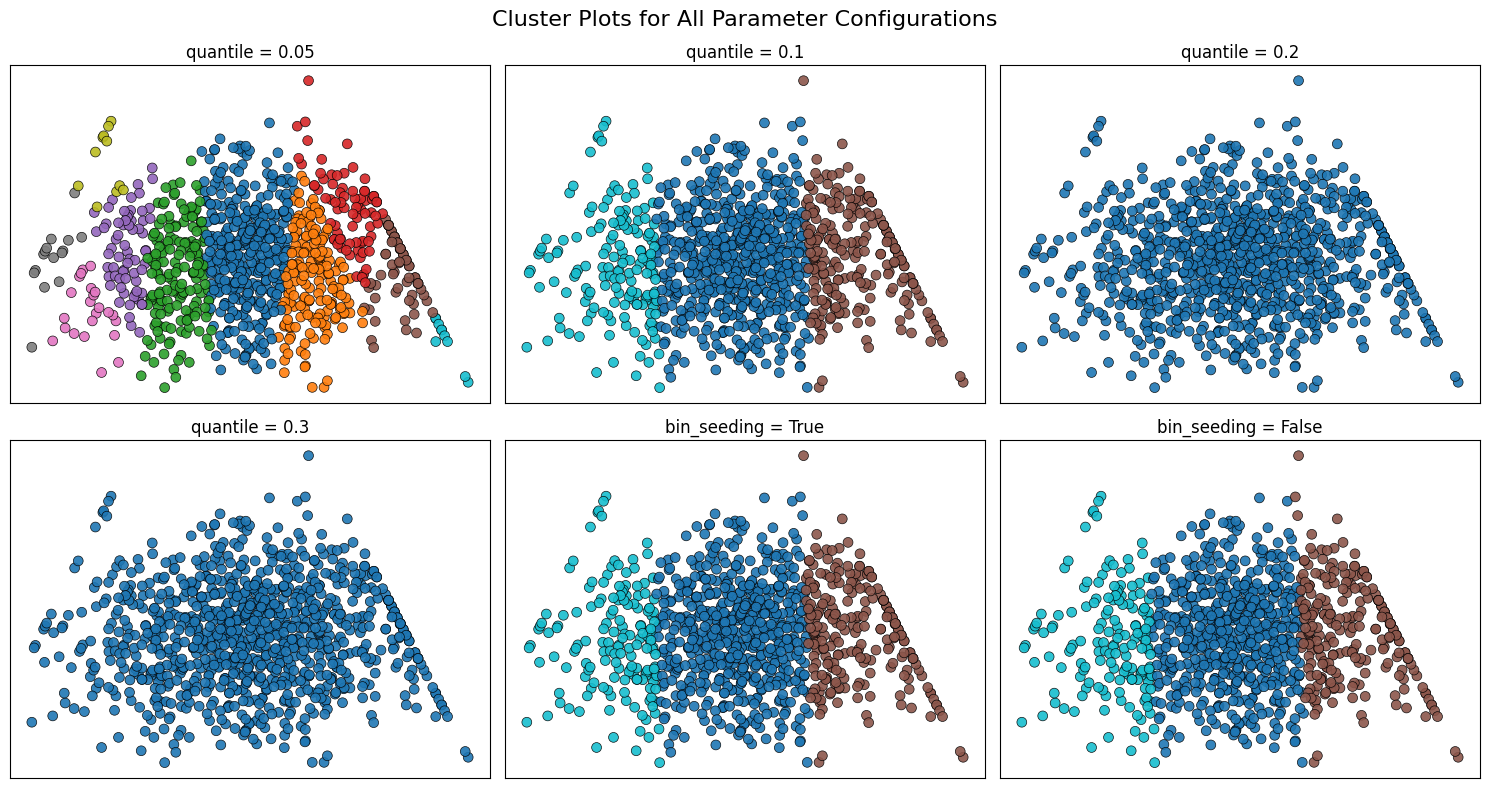

<IPython.core.display.Javascript object>

In [ ]:
meanshift_metrics = UNIVERSAL_METRICS
meanshift_params = {
    "quantile": [0.05, 0.1, 0.2, 0.3],
    "bin_seeding": [True, False],
}

MeanShiftFramework(
    data=processed_data['student'].data[['study_hours_per_day', 'exam_score']],
    metrics=MetricFactory(metrics=meanshift_metrics).get_metrics(),
    param_grid=meanshift_params,
    plot_groups=PlotFactory(meanshift_metrics).get_plots(),
).evaluate_model()

## (2) DBSCAN

In [ ]:
class DBSCANFramework(ClusteringFramework):
    def __init__(self, data, metrics, param_grid, plot_groups, eps, min_samples):
        super().__init__(data, metrics, param_grid, plot_groups)
        self.eps = eps
        self._eps = eps
        self.min_samples = min_samples
        self._min_samples = min_samples

    # --- Fit DBSCAN ---
    def fit(self, X=None) -> Tuple[np.ndarray, dict]:
        if X is None:
            X = self.data
        if X is None:
            raise ValueError("No data available. Please run preprocess() first.")

        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.model.fit(X)

        self.labels = self.model.labels_

        # Compute metrics
        results = self.evaluate(X)

        # Include parameter values
        param_values = {k: getattr(self, k) for k in self.param_grid.keys() if hasattr(self, k)}
        results.update(param_values)

        return self.labels, results

    # --- Reset model ---
    def reset_model(self):
        """Reinitialize DBSCAN model with current parameters."""
        self.eps = self._eps
        self.min_samples = self._min_samples
        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.labels = None

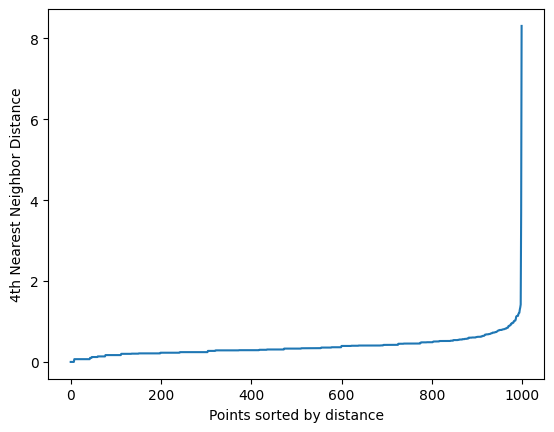

In [ ]:
dbscan_data = processed_data['student'].data[['study_hours_per_day', 'exam_score']]
X = dbscan_data.to_numpy()
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylabel("4th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.show()

✅ Scaled 1000 rows × 2 features


min_samples values: 100%|██████████| 5/5 [00:11<00:00,  2.22s/val, status=done, runtime_s=1.19, memory_MB=452.94, n_clusters=29, silhouette=-0.261]


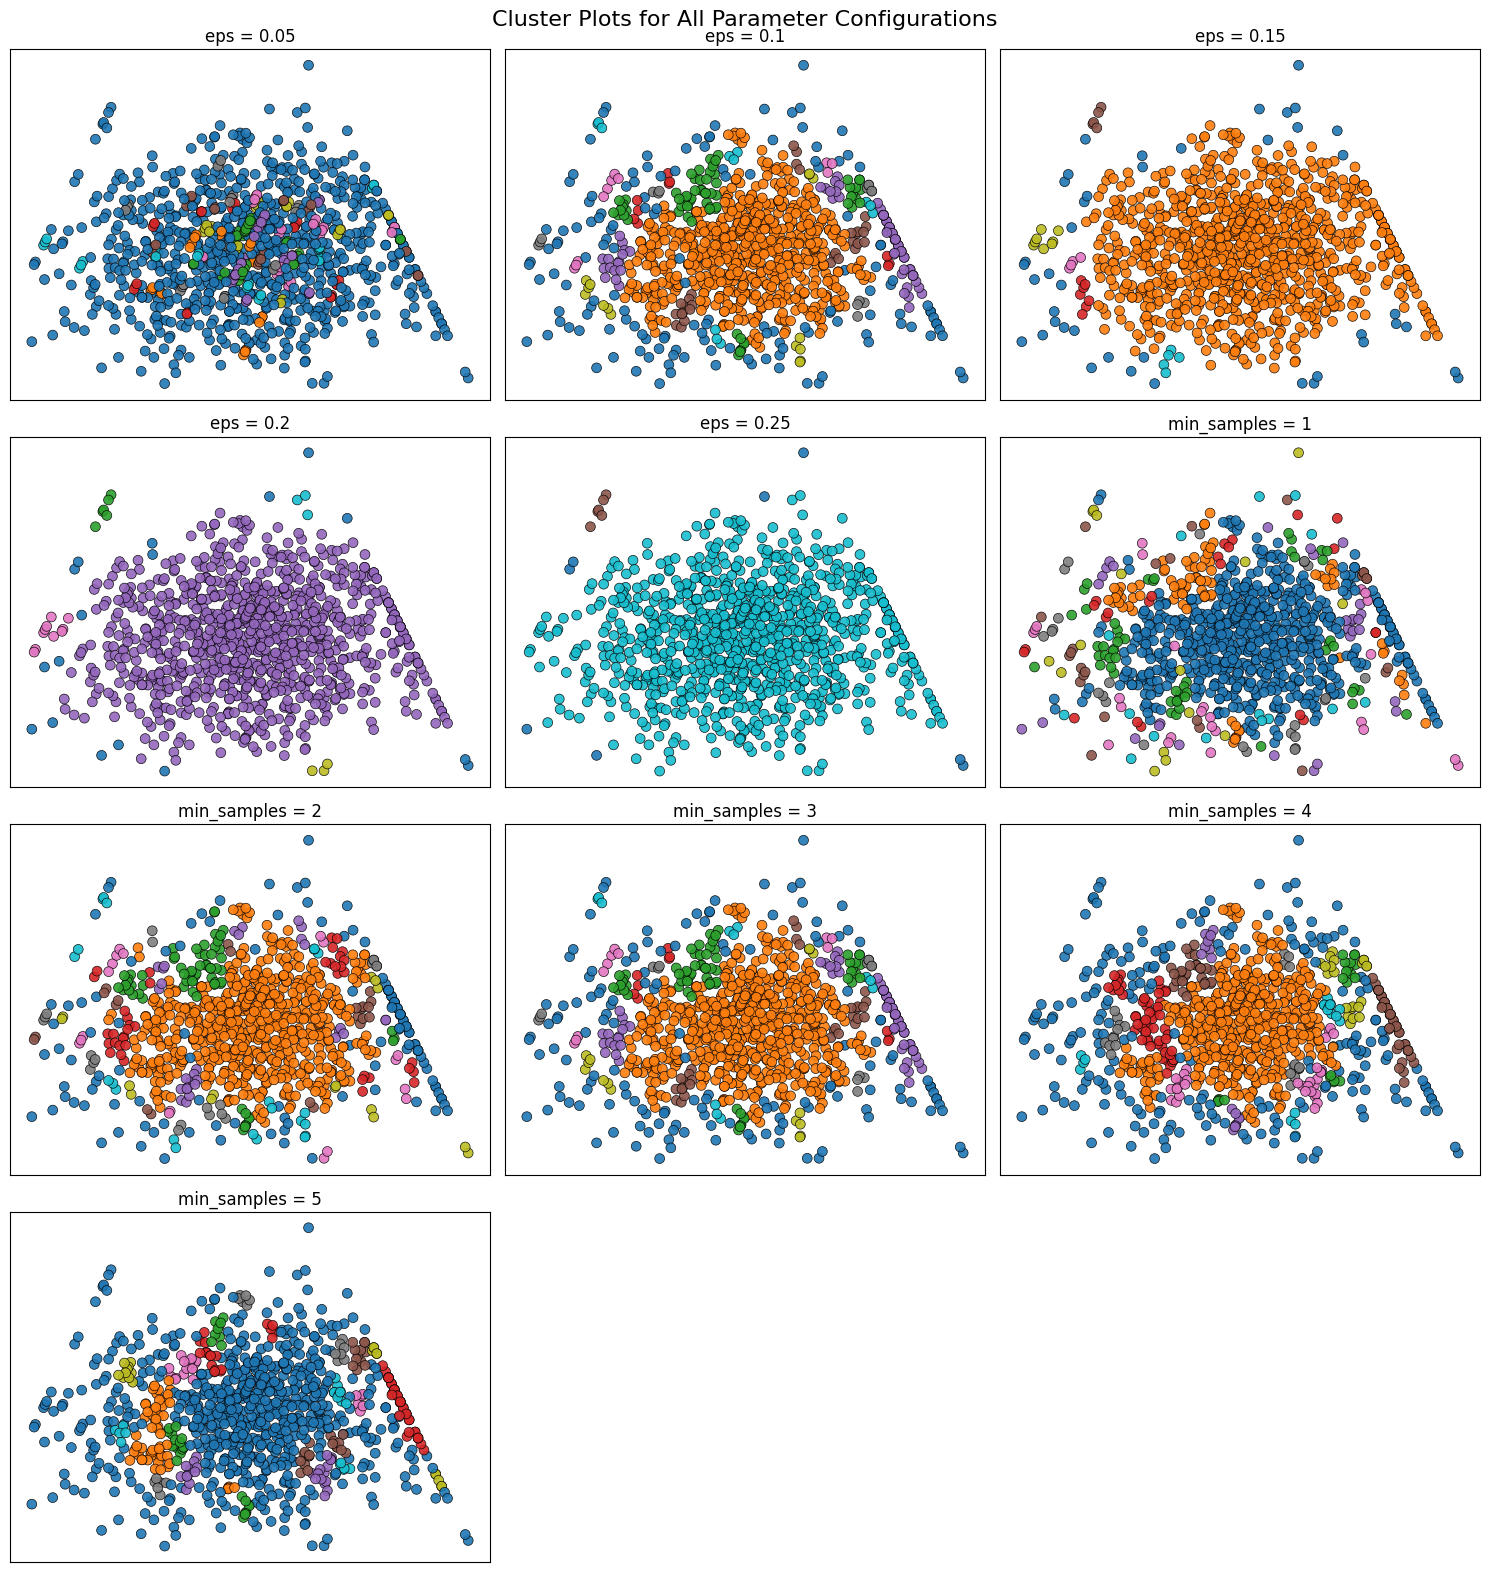

<IPython.core.display.Javascript object>

In [ ]:
dbscan_metrics = UNIVERSAL_METRICS + [
    ClusteringMetric.NOISE_FRACTION,
    ClusteringMetric.CORE_BORDER_RATIO,
    ClusteringMetric.AVG_CORE_DISTANCE,
]
dbscan_params = {
    "eps": [round(i*0.05, 2) for i in range(1, 6)],
    "min_samples": range(1, 6),
}

DBSCANFramework(
    data=dbscan_data,
    metrics=MetricFactory(metrics=dbscan_metrics).get_metrics(),
    param_grid=dbscan_params,
    plot_groups=PlotFactory(dbscan_metrics).get_plots(),
    eps=0.1,
    min_samples=3
).evaluate_model()


## (3) K-Means

In [ ]:
class KMeansFramework(ClusteringFramework):
    def __init__(self, data, metrics, param_grid, plot_groups, n_clusters, n_init, random_state):
        super().__init__(data, metrics, param_grid, plot_groups)
        self.n_clusters = n_clusters
        self._n_clusters = n_clusters
        self.n_init = n_init
        self._n_init = n_init
        self.random_state = random_state
        self.cluster_centers = None
        self.reset_model()  # initialize model

    # --- Fit KMeans ---
    def fit(self, X=None) -> Tuple[np.ndarray, dict]:
        if X is None:
            X = self.data
        if X is None:
            raise ValueError("No data available. Please run preprocess() first.")

        self.model = KMeans(
            n_clusters=self.n_clusters,
            n_init=self.n_init,
            random_state=self.random_state
        )
        self.model.fit(X)

        self.labels = self.model.labels_
        self.cluster_centers = self.model.cluster_centers_

        # Compute metrics
        results = self.evaluate(X)

        # Include parameter values
        param_values = {k: getattr(self, k) for k in self.param_grid.keys() if hasattr(self, k)}
        results.update(param_values)

        return self.labels, results

    # --- Reset model ---
    def reset_model(self):
        """Reinitialize the KMeans model with current parameters."""
        self.n_clusters = self._n_clusters
        self.n_init = self._n_init
        self.model = None
        self.labels = None
        self.cluster_centers = None

✅ Scaled 1000 rows × 2 features


n_init values: 100%|██████████| 4/4 [00:05<00:00,  1.48s/val, status=done, runtime_s=1.35, memory_MB=484.13, n_clusters=4, silhouette=0.383]


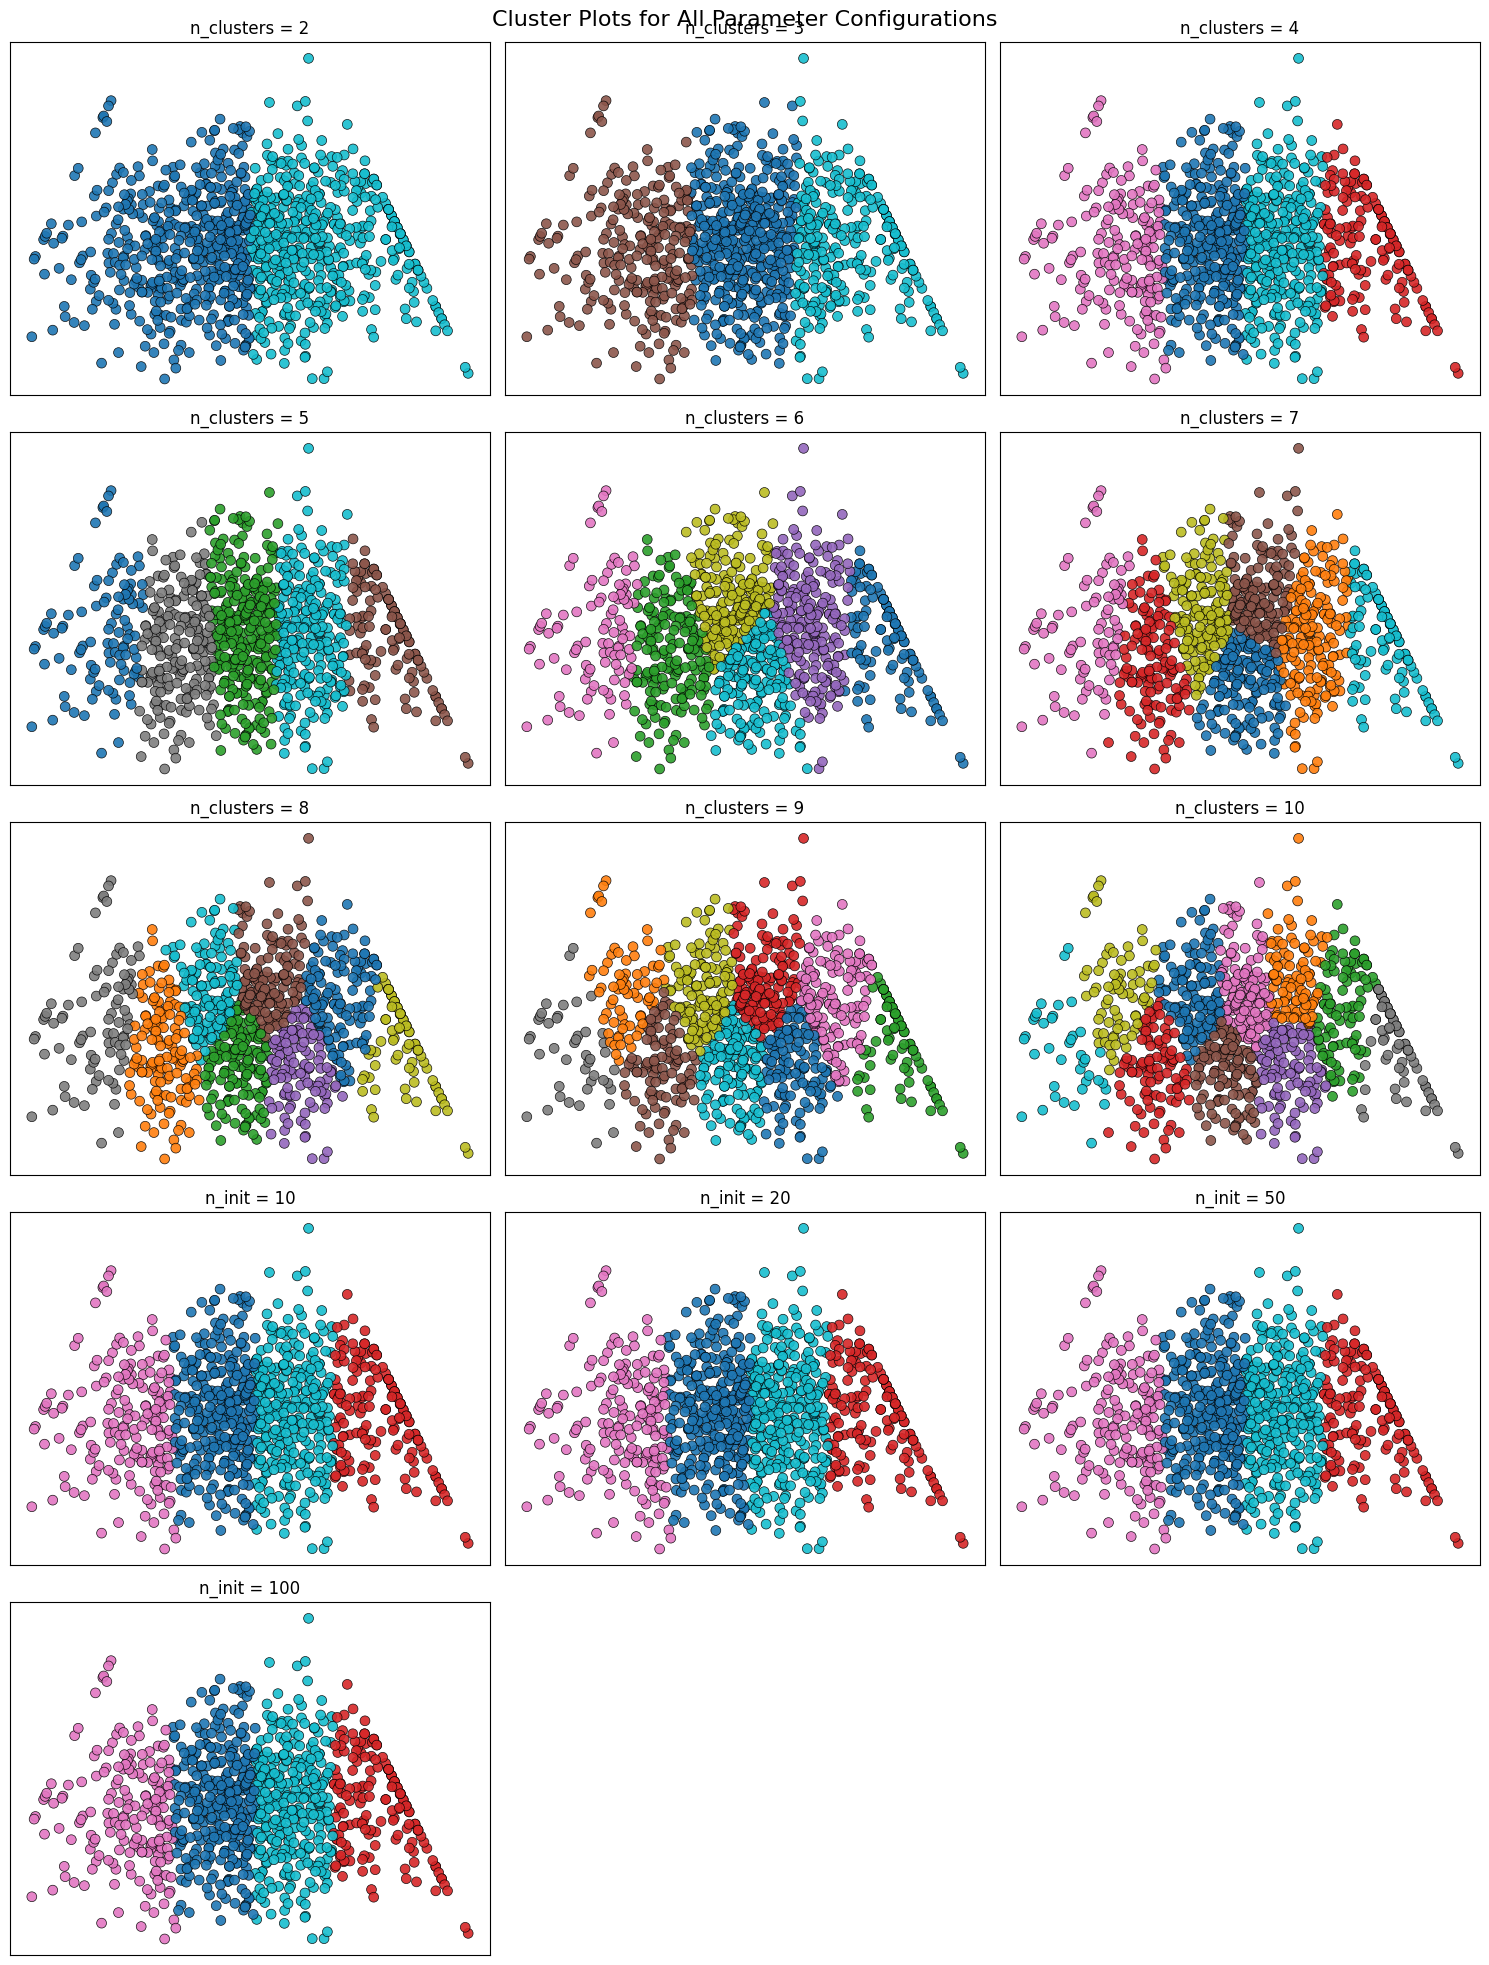

<IPython.core.display.Javascript object>

In [ ]:
kmeans_metrics = UNIVERSAL_METRICS + [ClusteringMetric.INERTIA, ClusteringMetric.N_ITER]
kmeans_params = {
    "n_clusters": range(2, 11),
    "n_init": [10, 20, 50, 100]
}

KMeansFramework(
    data=processed_data['student'].data[['study_hours_per_day', 'exam_score']],
    metrics=MetricFactory(metrics=kmeans_metrics).get_metrics(),
    param_grid=kmeans_params,
    plot_groups=PlotFactory(kmeans_metrics).get_plots(),
    n_clusters=4,
    n_init=60,
    random_state=42
).evaluate_model()